In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [249]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)





In [250]:
df = df.dropna().reset_index()


In [251]:
unique_stations_start = df.groupby('start_station_id').first().reset_index()

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])


df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60


df_start = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]


In [4]:
leisure_tags = ['park', 'cinema', 'theatre', 'museum', 'art_gallery', 'nightclub', 'zoo']
food_drink_tags = ['restaurant', 'cafe', 'bar', 'pub', 'biergarten']
shopping_tags = ['supermarket', 'mall', 'shop', 'boutique', 'marketplace']
business_industrial_tags = ['office', 'industrial', 'commercial', 'factory']
residential_tags = ['residential', 'apartments', 'house', 'housing_estate']
education_research_tags = ['school', 'university', 'college', 'library', 'research_institute']
health_medical_tags = ['hospital', 'clinic', 'pharmacy', 'veterinary', 'dentist']
public_service_tags = ['police', 'fire_station', 'post_office', 'townhall', 'courthouse']
transport_mobility_tags = ['bus_station', 'train_station', 'airport', 'bicycle_parking', 'car_rental']
sport_activity_tags = ['stadium', 'sports_centre', 'gym', 'swimming_pool', 'playground']

all_tags = {
    'Leisure': leisure_tags,
    'Food_Drink': food_drink_tags,
    'Shopping': shopping_tags,
    'Business_Industrial': business_industrial_tags,
    'Residential': residential_tags,
    'Education_Research': education_research_tags,
    'Health_Medical': health_medical_tags,
    'Public_Service': public_service_tags,
    'Transport_Mobility': transport_mobility_tags,
    'Sport_Activity': sport_activity_tags
}


def classify_poi(poi):
    for category, tags in all_tags.items():
        if any(tag in poi for tag in tags):
            return category
    return 'Other'

In [40]:
def classify_poi(poi):
    categories = []
    for category, tags in all_tags.items():
        if any(tag in poi for tag in tags):
            categories.append(category)
    return categories if categories else ['Other']

def get_pois(lat, lng, dist=250):  
    try:
        point = (lat, lng)
        tags = {
            'landuse': ['residential'],
            'amenity': True,
            'leisure': True,
            'shop': True,
            'tourism': True,
            'office': True
        }
        pois = ox.features_from_point(point, tags, dist=dist)
        if not pois.empty:
            pois['category'] = pois.apply(lambda row: classify_poi(row), axis=1)  
        return pois if not pois.empty else pd.DataFrame()
    except Exception as e:
        print(e) 
        return pd.DataFrame()


unique_stations['pois'] = unique_stations.apply(lambda row: get_pois(row['start_lat'], row['start_lng']), axis=1)

poi_data = []

for index, row in unique_stations.iterrows():
    if not row['pois'].empty:
        for _, poi_row in row['pois'].iterrows():
            for category in poi_row['category']:  
                poi_data.append({
                    'start_station_name': row['start_station_name'],
                    'category': category,
                    'geometry': poi_row['geometry']
                })

poi_df = pd.DataFrame(poi_data)
poi_counts_df = poi_df.groupby(['start_station_name', 'category']).size().unstack(fill_value=0)

print(poi_counts_df.head())

No data elements in server response. Check log and query location/tags.
category                      Business_Industrial  Education_Research  \
start_station_name                                                      
10101 S Stony Island Ave                        0                   0   
111th St - Morgan Park Metra                    0                   0   
2112 W Peterson Ave                             0                   0   
410                                             0                   0   
532 E 43rd St                                   0                   0   

category                      Food_Drink  Leisure  Other  Residential  \
start_station_name                                                      
10101 S Stony Island Ave               0        0      1            0   
111th St - Morgan Park Metra           0        0     21            0   
2112 W Peterson Ave                    0        0      0            0   
410                                    0        0  

In [38]:
def get_pois(lat, lng, dist=250):  
    try:
        point = (lat, lng)
        tags = {
            'landuse': ['residential'],
            'amenity': True,
            'leisure': True,
            'shop': True,
            'tourism': True,
            'office': True
        }
        pois = ox.features_from_point(point, tags, dist=dist)
        if not pois.empty:
            pois['category'] = pois.apply(classify_poi, axis=1)  
        return pois if not pois.empty else pd.DataFrame()
    except Exception as e:
        print(e) 
        return pd.DataFrame()


unique_stations['pois'] = unique_stations.apply(lambda row: get_pois(row['start_lat'], row['start_lng']), axis=1)


poi_data = []


for index, row in unique_stations.iterrows():
    if not row['pois'].empty:
        for _, poi_row in row['pois'].iterrows():
            poi_data.append({
                'start_station_name': row['start_station_name'],
                'category': poi_row['category'],
                'geometry': poi_row['geometry']
            })


poi_df = pd.DataFrame(poi_data)
poi_counts_df = poi_df.groupby(['start_station_name', 'category']).size().unstack(fill_value=0)

print(poi_counts_df.head())


No data elements in server response. Check log and query location/tags.
category                      Business_Industrial  Food_Drink  Leisure  Other  \
start_station_name                                                              
10101 S Stony Island Ave                        0           0        0      1   
111th St - Morgan Park Metra                    0           0        0     21   
2112 W Peterson Ave                             0           0        0      0   
410                                             0           0        0      0   
532 E 43rd St                                   0           0        0      0   

category                      Residential  Shopping  Sport_Activity  \
start_station_name                                                    
10101 S Stony Island Ave                0         0               0   
111th St - Morgan Park Metra            0         0               0   
2112 W Peterson Ave                     0        17               0   
410  

In [42]:
sum = poi_counts_df.sum()

In [43]:
sum

category
Business_Industrial    33610
Education_Research      1142
Food_Drink              6320
Leisure                 8445
Other                   7297
Residential             8856
Shopping               51968
Sport_Activity          9977
Transport_Mobility     26540
dtype: int64

In [ ]:
poi_counts_df = pd.read_csv('/Users/mariu/master_thesis/poi_counts_df_250.csv')

In [ ]:
poi_counts_df = pd.read_csv('/Users/mariu/master_thesis/poi_counts_df.csv')

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

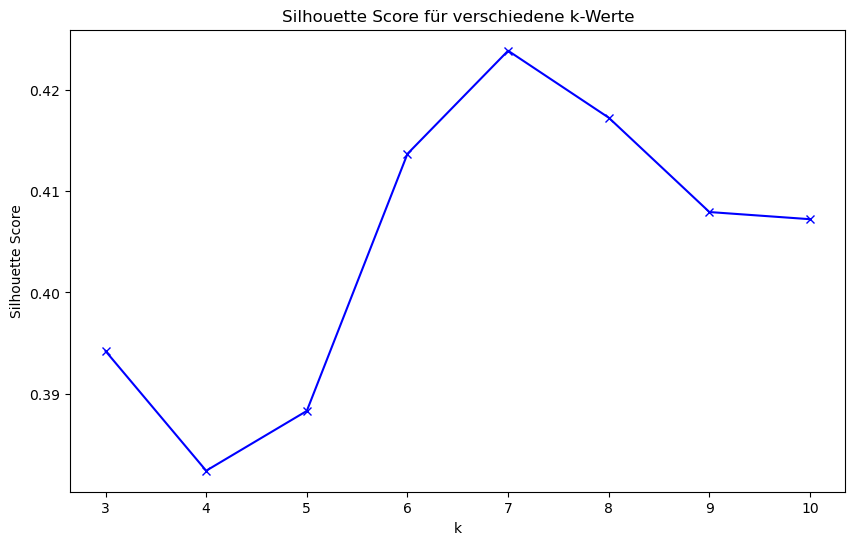

Optimales k: 7


/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


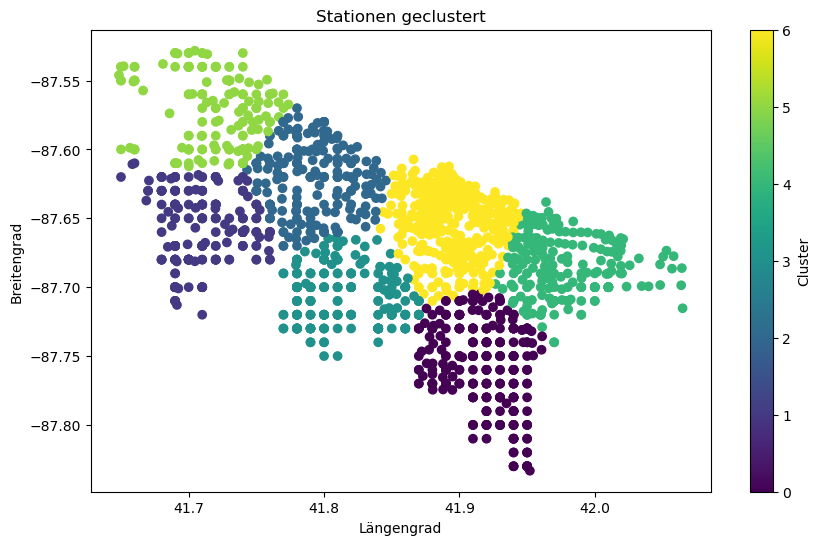

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



silhouette_scores = []
K_range = range(3, 11)  
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42).fit(unique_stations[['start_lat', 'start_lng']])
    score = silhouette_score(unique_stations[['start_lat', 'start_lng']], kmeans.labels_)
    silhouette_scores.append(score)


plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score für verschiedene k-Werte')
plt.show()


optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimales k: {optimal_k}')


kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42).fit(unique_stations[['start_lat', 'start_lng']])
unique_stations['cluster'] = kmeans_optimal.labels_


plt.figure(figsize=(10, 6))
plt.scatter(unique_stations['start_lat'], unique_stations['start_lng'], c=unique_stations['cluster'], cmap='viridis', marker='o')
plt.title('Stationen geclustert')
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.colorbar(label='Cluster')
plt.show()


In [44]:

station_to_cluster_map = unique_stations.set_index('start_station_name')['cluster'].to_dict()


df['cluster'] = df['start_station_name'].map(station_to_cluster_map)

In [45]:
cluster_counts = unique_stations['cluster'].value_counts()

cluster_counts

6    340
0    304
3    239
1    223
2    220
4    217
5    179
Name: cluster, dtype: int64

In [46]:
cluster_counts = df['cluster'].value_counts()

cluster_counts

6.0    3032682
4.0     627798
2.0     203466
0.0      81888
3.0      25857
5.0      11530
1.0       7502
Name: cluster, dtype: int64

In [47]:
df['start_hour'] = df['started_at'].dt.hour


start_time_distribution_per_cluster = df.groupby(['cluster', 'start_hour']).size().unstack(fill_value=0)


total_rides_per_cluster = start_time_distribution_per_cluster.sum(axis=1)


percent_distribution_per_cluster = start_time_distribution_per_cluster.div(total_rides_per_cluster, axis=0) * 100

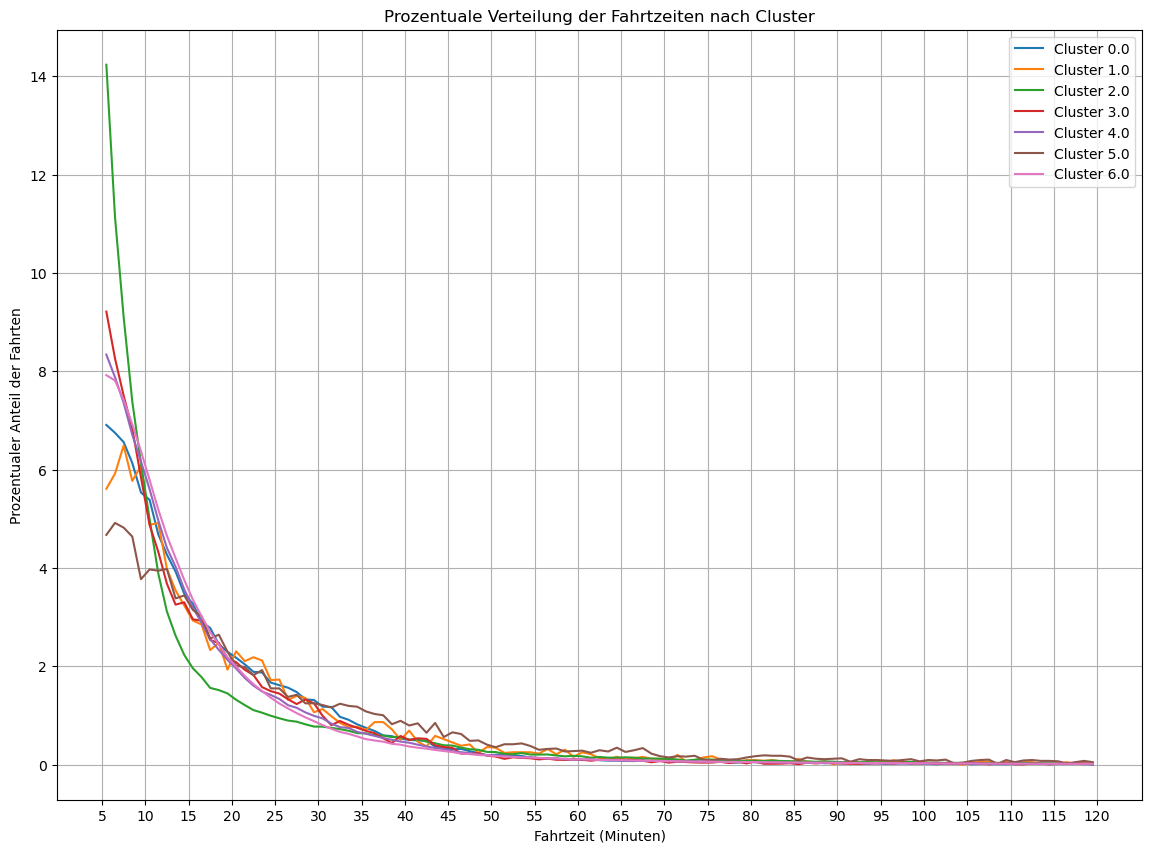

In [48]:

df['time_interval'] = pd.cut(df['ride_duration'], bins=np.arange(5, 121, 1), right=False)


ride_counts_per_interval_cluster = df.groupby(['cluster', 'time_interval']).size().unstack(fill_value=0)


total_rides_per_cluster = ride_counts_per_interval_cluster.sum(axis=1)


percent_distribution_per_interval_cluster = (ride_counts_per_interval_cluster.T / total_rides_per_cluster).T * 100


plt.figure(figsize=(14, 10))
for cluster in percent_distribution_per_interval_cluster.index:
    plt.plot(percent_distribution_per_interval_cluster.columns.categories.mid, percent_distribution_per_interval_cluster.loc[cluster], label=f'Cluster {cluster}')

plt.xlabel('Fahrtzeit (Minuten)')
plt.ylabel('Prozentualer Anteil der Fahrten')
plt.title('Prozentuale Verteilung der Fahrtzeiten nach Cluster')
plt.legend()
plt.xticks(np.arange(5, 121, 5))
plt.grid(True)
plt.show()

In [49]:

merged_df = pd.merge(unique_stations, poi_counts_df, on='start_station_name', how='left')

print(merged_df.head())


             start_station_name           ride_id  rideable_type  \
0      10101 S Stony Island Ave  F715C83C9A4E9B18  electric_bike   
1  111th St - Morgan Park Metra  54932094E964F02A  electric_bike   
2           2112 W Peterson Ave  0B3343C0A131B87E  electric_bike   
3                           410  0DA511E177690708  electric_bike   
4                 532 E 43rd St  66C14540F47D3BE4  electric_bike   

            started_at             ended_at start_station_id  \
0  2022-08-13 19:58:36  2022-08-13 20:25:52              922   
1  2022-05-09 16:50:29  2022-05-09 16:57:23              682   
2  2022-05-07 13:39:17  2022-05-07 14:06:41     KA1504000155   
3  2023-04-27 07:36:16  2023-04-27 07:48:35              410   
4  2022-05-27 10:53:54  2022-05-27 11:07:59              913   

             end_station_name end_station_id  start_lat  start_lng  ...  \
0      Phillips Ave & 83rd St            582  41.710000   -87.5800  ...   
1      Walden Pkwy & 103rd St            693  41.690000 

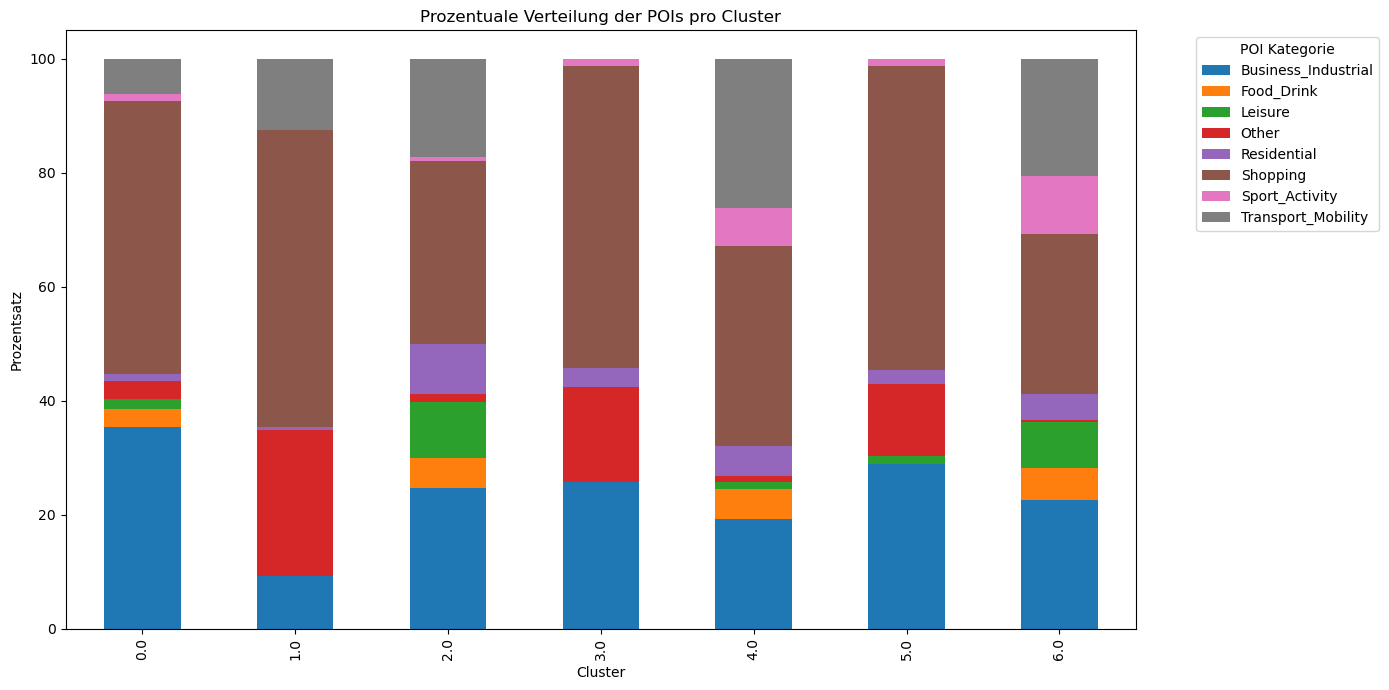

In [50]:
import matplotlib.pyplot as plt
import pandas as pd



merged_df = pd.merge(df, poi_counts_df, on='start_station_name', how='left')


poi_sum_per_cluster = merged_df.groupby('cluster')[['Business_Industrial', 'Food_Drink', 'Leisure', 'Other', 'Residential', 'Shopping', 'Sport_Activity', 'Transport_Mobility']].sum()


poi_percentage_per_cluster = poi_sum_per_cluster.div(poi_sum_per_cluster.sum(axis=1), axis=0) * 100


poi_percentage_per_cluster.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Prozentuale Verteilung der POIs pro Cluster')
plt.ylabel('Prozentsatz')
plt.xlabel('Cluster')
plt.legend(title='POI Kategorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


In [51]:
average_ride_duration_per_cluster = df.groupby('cluster')['ride_duration'].mean()
average_ride_duration_per_cluster

cluster
0.0    18.666792
1.0    20.972270
2.0    17.924310
3.0    17.804907
4.0    17.699970
5.0    25.302456
6.0    17.442412
Name: ride_duration, dtype: float64

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Angenommen df ist Ihr DataFrame
# Umwandlung der Zeitstempel in Stunden, falls dies noch nicht geschehen ist
df['started_at_hour'] = pd.to_datetime(df['started_at']).dt.hour
df['ended_at_hour'] = pd.to_datetime(df['ended_at']).dt.hour

# Einbeziehung der Fahrtdauer, Start- und Endstunde als Features
features_to_focus_on = ['ride_duration', 'started_at_hour', 'ended_at_hour']

# Normalisierung der Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_to_focus_on])

# Anwendung des K-Means-Clustering
kmeans = KMeans(n_clusters=5)  # Die Anzahl der Cluster muss bestimmt werden
df['time_focus_cluster'] = kmeans.fit_predict(scaled_features)

# Ergebnis
print(df[['start_station_id', 'end_station_id', 'time_focus_cluster']].head())


/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  start_station_id end_station_id  time_focus_cluster
0     TA1307000117   TA1309000025                   2
1            13300          15534                   1
2     TA1305000032          13221                   2
3     TA1305000032   TA1305000030                   1
4     TA1305000032   TA1306000015                   2


/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

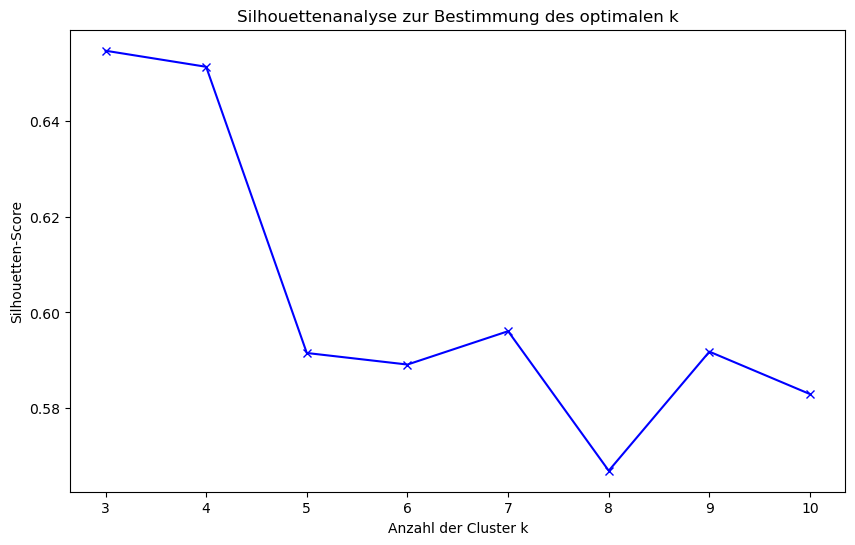

In [252]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_start.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='start_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['start_station_id'] + sorted([col for col in pivot_df.columns if col != 'start_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('start_station_id', axis=1)

# Normalisierung der Features, da die Skala der Fahrtanzahlen sehr unterschiedlich sein kann
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

silhouette_scores = []
K = range(3, 11)  # Silhouetten-Score kann nicht mit k=1 berechnet werden
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Anzahl der Cluster k')
plt.ylabel('Silhouetten-Score')
plt.title('Silhouettenanalyse zur Bestimmung des optimalen k')
plt.show()


In [253]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_start.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='start_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['start_station_id'] + sorted([col for col in pivot_df.columns if col != 'start_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('start_station_id', axis=1)

# Normalisierung der Features, da die Skala der Fahrtanzahlen sehr unterschiedlich sein kann
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Anwendung des K-Means-Clustering
kmeans = KMeans(n_clusters=4)  # Die Anzahl der Cluster kann angepasst werden, basierend auf der spezifischen Analyse
clusters = kmeans.fit_predict(scaled_features)

# Hinzufügen der Cluster-Zuweisungen zum DataFrame
pivot_df['cluster'] = clusters

# Ergebnis anzeigen
print(pivot_df.head())


/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


weekday_hour start_station_id  0_00  0_01  0_02  0_03  0_04  0_05  0_06  0_07  \
0                      021320     0     0     0     0     0     0     1     2   
1                        1011     0     0     0     0     0     0     0     2   
2                        1012     0     0     0     0     0     0     0     0   
3                        1013     0     0     0     0     0     0     0     0   
4                        1014     0     0     0     0     0     0     0     0   

weekday_hour  0_08  ...  6_15  6_16  6_17  6_18  6_19  6_20  6_21  6_22  6_23  \
0                1  ...     8     1     0     0     0     0     1     8     2   
1                0  ...     0     0     1     0     0     1     0     0     0   
2                0  ...     0     1     0     0     0     0     0     0     0   
3                0  ...     0     0     0     0     0     0     0     1     0   
4                0  ...     0     0     0     0     0     0     0     0     0   

weekday_hour  cluster  
0 

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

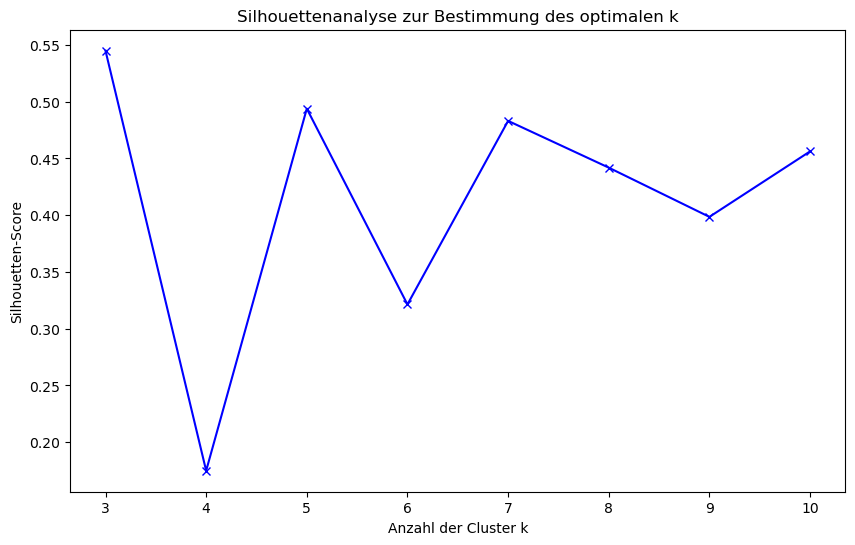

In [224]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Berechnung der Gesamtzahl der Fahrten pro Station
total_rides_per_station = df.groupby('start_station_id')['ride_id'].count().reset_index(name='total_rides')

# Berechnung der Anzahl der Fahrten pro Station, Wochentag und Stunde
rides_per_station_weekday_hour = df.groupby(['start_station_id', 'weekday_hour'])['ride_id'].count().reset_index(name='rides')

# Zusammenführen der Gesamtzahl der Fahrten mit den stündlichen Fahrten
merged = pd.merge(rides_per_station_weekday_hour, total_rides_per_station, on='start_station_id')

# Berechnung des prozentualen Anteils der stündlichen Fahrten von den Gesamtfahrten jeder Station
merged['percentage'] = (merged['rides'] / merged['total_rides']) * 100

# Pivotierung der Daten, um jede Station als eine Zeile und jede 'weekday_hour' Kombination als eine Spalte zu haben
pivot_table = merged.pivot_table(index='start_station_id', columns='weekday_hour', values='percentage', fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren, ohne 'start_station_id' zu berücksichtigen
sorted_columns = ['start_station_id'] + sorted([col for col in pivot_table.columns if col != 'start_station_id'])
pivot_table = pivot_table[sorted_columns]

# Extraktion der Features für das Clustering
features = pivot_table.drop('start_station_id', axis=1)

# Normalisierung der Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

silhouette_scores = []
K = range(3, 11)  # Silhouetten-Score kann nicht mit k=1 berechnet werden
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Anzahl der Cluster k')
plt.ylabel('Silhouetten-Score')
plt.title('Silhouettenanalyse zur Bestimmung des optimalen k')
plt.show()
# Anwendung des K-Means-Clustering
#kmeans = KMeans(n_clusters=3)  # Anpassung der Clusteranzahl möglich
#clusters = kmeans.fit_predict(scaled_features)

# Hinzufügen der Cluster-Zuweisungen zum DataFrame
#pivot_table['cluster'] = clusters

# Ergebnis anzeigen
#print(pivot_table.head())


In [238]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Berechnung der Gesamtzahl der Fahrten pro Station
total_rides_per_station = df.groupby('start_station_id')['ride_id'].count().reset_index(name='total_rides')

# Berechnung der Anzahl der Fahrten pro Station, Wochentag und Stunde
rides_per_station_weekday_hour = df.groupby(['start_station_id', 'weekday_hour'])['ride_id'].count().reset_index(name='rides')

# Zusammenführen der Gesamtzahl der Fahrten mit den stündlichen Fahrten
merged = pd.merge(rides_per_station_weekday_hour, total_rides_per_station, on='start_station_id')

# Berechnung des prozentualen Anteils der stündlichen Fahrten von den Gesamtfahrten jeder Station
merged['percentage'] = (merged['rides'] / merged['total_rides']) * 100

# Pivotierung der Daten, um jede Station als eine Zeile und jede 'weekday_hour' Kombination als eine Spalte zu haben
pivot_table = merged.pivot_table(index='start_station_id', columns='weekday_hour', values='percentage', fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren, ohne 'start_station_id' zu berücksichtigen
sorted_columns = ['start_station_id'] + sorted([col for col in pivot_table.columns if col != 'start_station_id'])
pivot_table = pivot_table[sorted_columns]

# Extraktion der Features für das Clustering
features = pivot_table.drop('start_station_id', axis=1)

# Normalisierung der Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Anwendung des K-Means-Clustering
kmeans = KMeans(n_clusters=3)  # Anpassung der Clusteranzahl möglich
clusters = kmeans.fit_predict(scaled_features)

# Hinzufügen der Cluster-Zuweisungen zum DataFrame
pivot_table['cluster'] = clusters

# Ergebnis anzeigen
print(pivot_table.head())


/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


weekday_hour start_station_id  0_00  0_01  0_02  0_03  0_04  0_05      0_06  \
0                      021320   0.0   0.0   0.0   0.0   0.0   0.0  0.223214   
1                        1011   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
2                        1012   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
3                        1013   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
4                        1014   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   

weekday_hour      0_07      0_08  ...      6_15       6_16      6_17  6_18  \
0             0.446429  0.223214  ...  1.785714   0.223214  0.000000   0.0   
1             7.142857  0.000000  ...  0.000000   0.000000  3.571429   0.0   
2             0.000000  0.000000  ...  0.000000  25.000000  0.000000   0.0   
3             0.000000  0.000000  ...  0.000000   0.000000  0.000000   0.0   
4             0.000000  0.000000  ...  0.000000   0.000000  0.000000   0.0   

weekday_hour  6_19      6_20      6_21       6_22      6

In [263]:
import numpy as np
import pandas as pd

# Angenommen, 'df' ist dein DataFrame mit den Spalten 'start_station_id', 'hour', 'weekday', und 'ride_id'

# Schritt 1: Aggregation der Fahrten pro Stunde und Wochentag für jede Station
station_hour_weekday_counts = df.groupby(['start_station_id', 'weekday', 'hour'])['ride_id'].count().reset_index(name='ride_counts')

# Schritt 2: Umwandlung in ein Pivot-Table, um Feature-Vektoren für jede Station zu erstellen
pivot_df = station_hour_weekday_counts.pivot_table(index='start_station_id', columns=['weekday', 'hour'], values='ride_counts', fill_value=0)

# Angenommen, du hast bereits ein DataFrame 'clusters' mit den Spalten 'start_station_id' und 'cluster', das die Cluster-Zuweisung für jede Station angibt
pivot_df = pivot_df.merge(unique_stations[['start_station_id', 'cluster']], on='start_station_id')

# Schritt 3: Berechnung des durchschnittlichen Feature-Vektors für jeden Cluster
cluster_feature_vectors = pivot_df.groupby('cluster').mean()

# 'cluster_feature_vectors' enthält jetzt für jeden Cluster einen durchschnittlichen Feature-Vektor, der die typische Verteilung der Fahrten über Stunden und Tage für die Stationen in diesem Cluster zeigt


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2713/3625683631.py:13: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  pivot_df = pivot_df.merge(unique_stations[['start_station_id', 'cluster']], on='start_station_id')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2713/3625683631.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_feature_vectors = pivot_df.groupby('cluster').mean()


In [86]:
cluster_feature_vectors

(0, 0)     (0, 1)    (0, 2)    (0, 3)    (0, 4)     (0, 5)  \
cluster                                                                  
0         0.421998   0.249158  0.161616  0.147026  0.221100   0.306397   
1        19.573770  11.901639  6.590164  4.229508  3.557377  19.344262   
2         5.162791   2.622093  1.488372  1.250000  1.988372   5.122093   
3        30.714286  11.571429  6.285714  4.714286  4.000000   9.285714   
4        12.078740   6.519685  3.881890  2.771654  2.692913   9.724409   

            (0, 6)      (0, 7)      (0, 8)      (0, 9)  ...     (6, 14)  \
cluster                                                 ...               
0         0.878788    1.653199    1.898990    1.483726  ...    3.149270   
1        66.688525  109.983607  125.311475   74.950820  ...  203.311475   
2        15.924419   29.767442   36.156977   24.052326  ...   49.180233   
3        38.285714   83.000000  115.000000  109.285714  ...  702.857143   
4        30.377953   61.724409   75.181102   47.078740  ...  109.488189   

            (6, 15)     (6, 16)     (6, 17)     (6, 18)     (6, 19)  \
cluster                                                               
0          3.092031    3.133558    2.711560    2.505051    2.005612   
1        220.770492  208.770492  190.885246  167.606557  124.655738   
2         49.546512   47.226744   43.965116   39.686047   29.662791   
3        791.285714  750.571429  637.428571  465.428571  343.571429   
4        109.803150  109.228346  102.173228   88.535433   65.251969   

            (6, 20)     (6, 21)    (6, 22)    (6, 23)  
cluster                                                
0          1.476992    1.184063   1.223345   0.671156  
1         86.868852   70.278689  55.606557  34.360656  
2         22.069767   17.982558  14.645349   8.796512  
3        209.285714  130.428571  80.285714  49.857143  
4         48.992126   39.086614  30.944882  19.047244  

[5 rows x 168 columns]

In [264]:
from sklearn.metrics.pairwise import cosine_similarity

# Angenommen, 'cluster_vectors' ist ein Array von Feature-Vektoren für die Cluster
# Beispiel: cluster_vectors = [vector1, vector2, vector3, ...]

# Berechnung der Cosine-Similarity-Matrix
similarity_matrix = cosine_similarity(cluster_feature_vectors)

# Anzeigen der Cosine-Similarity-Matrix
print(similarity_matrix)


[[1.         0.99022223 0.99306799 0.92453461]
 [0.99022223 1.         0.98851391 0.91278761]
 [0.99306799 0.98851391 1.         0.90179211]
 [0.92453461 0.91278761 0.90179211 1.        ]]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Angenommen, 'df' ist dein DataFrame mit den Spalten 'start_station_id', 'hour', 'weekday', und 'rides_count'


# Schritt 2 & 3: Umwandlung in ein Pivot-Table, um Feature-Vektoren für jede Station zu erstellen
pivot_df = df.pivot_table(index='start_station_id', columns=['weekday', 'hour'], values='percentage', fill_value=0)

# Schritt 4: Cluster-Zugehörigkeit zu 'pivot_df' hinzufügen
# Angenommen, 'clusters' ist ein DataFrame mit den Spalten 'start_station_id' und 'cluster'
pivot_df = pivot_df.merge(clusters, on='start_station_id')

# Berechnung des durchschnittlichen Feature-Vektors für jeden Cluster
cluster_feature_vectors = pivot_df.groupby('cluster').mean()

In [254]:
df = df_start.merge(pivot_df[['start_station_id', 'cluster']], on='start_station_id', how='left')

In [240]:
df_2= df.merge(pivot_table[['start_station_id', 'cluster']], on='start_station_id', how='left')

In [255]:
unique_stations = unique_stations_start.merge(pivot_df[['start_station_id', 'cluster']], on='start_station_id', how='left')

In [241]:
unique_stations_2 = unique_stations_start.merge(pivot_table[['start_station_id', 'cluster']], on='start_station_id', how='left')

In [184]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts = unique_stations['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts)


2.0    962
0.0    221
1.0     75
Name: cluster, dtype: int64


In [256]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts = unique_stations['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts)

0.0    958
2.0    209
1.0     84
3.0      7
Name: cluster, dtype: int64


In [257]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_df = df['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_df)


2    1561336
1    1351995
0     458284
3     251197
Name: cluster, dtype: int64


In [ ]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_df = df['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_df)

In [242]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_2= df_2['cluster_y'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_2)

1    3615415
0       7391
2          6
Name: cluster_y, dtype: int64


In [243]:
# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_2= unique_stations_2['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_2)

1.0    1040
0.0     215
2.0       3
Name: cluster, dtype: int64


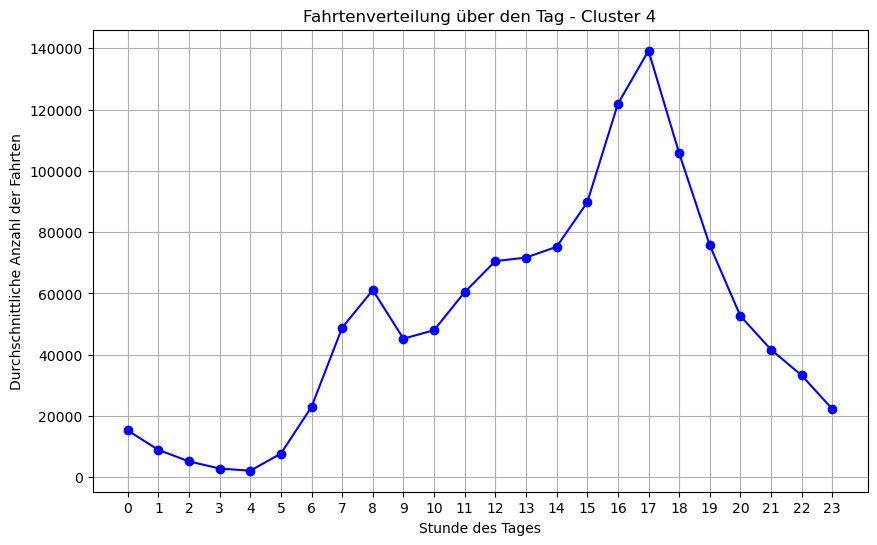

In [133]:
import matplotlib.pyplot as plt

# Angenommen, Sie haben einen DataFrame df, der 'time_focus_cluster', 'hour' und 'ride_id' enthält

# Wählen Sie einen spezifischen Cluster aus, z.B. Cluster 0
selected_cluster = 4

# Aggregieren der Daten: Durchschnittliche Fahrtenzahl pro Stunde für den ausgewählten Cluster
average_rides_per_hour = df[df['cluster'] == selected_cluster].groupby('hour').ride_id.count().reset_index(name='average_rides')

# Plotten der durchschnittlichen Fahrtenzahl pro Stunde für den ausgewählten Cluster
plt.figure(figsize=(10, 6))
plt.plot(average_rides_per_hour['hour'], average_rides_per_hour['average_rides'], marker='o', linestyle='-', color='blue')
plt.title(f'Fahrtenverteilung über den Tag - Cluster {selected_cluster}')
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittliche Anzahl der Fahrten')
plt.xticks(range(0, 24))  # Stellen Sie sicher, dass alle Stunden markiert sind
plt.grid(True)
plt.show()


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2713/1182759400.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'started_at'] = pd.to_datetime(df['started_at'])


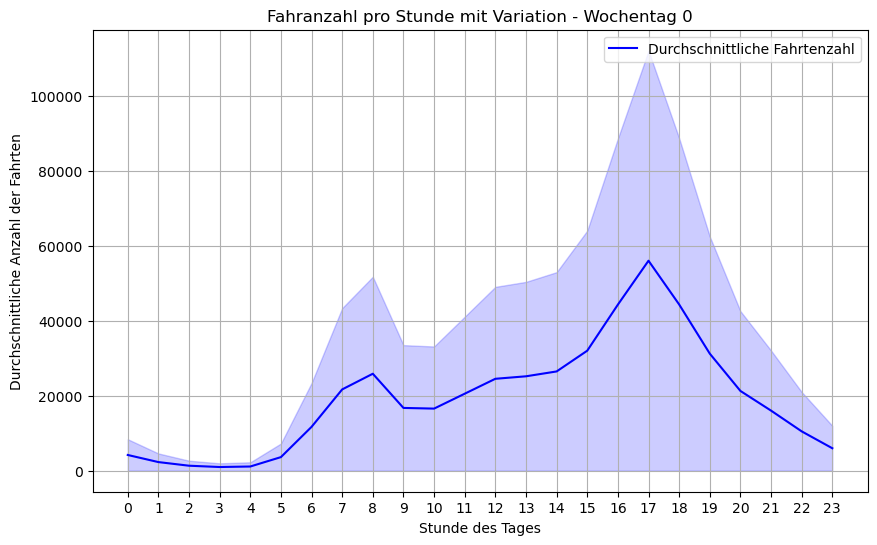

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Stellen Sie sicher, dass 'df' nicht nur eine Sicht (view) oder eine Kopie eines anderen DataFrame ist.
# Wenn 'df' von einem anderen DataFrame abgeleitet ist, erstellen Sie eine explizite Kopie mit df.copy(), um sicherzugehen.
df = df.copy()

# Korrigieren Sie die Zuweisungen unter Verwendung von .loc
df.loc[:, 'started_at'] = pd.to_datetime(df['started_at'])
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.weekday


# Beispielannahme: Wir verwenden df_copy und haben bereits 'hour' und 'weekday' berechnet

# Berechnung der durchschnittlichen Fahrtenzahl und Standardabweichung pro Stunde und Wochentag
stats = df.groupby(['weekday', 'hour']).agg(
    average_rides=('ride_id', 'count'),  # Ersetzen Sie 'ride_id' durch eine geeignete Zählspalte
    std_dev=('ride_id', 'count')  # Beispiel: Verwenden Sie dieselbe Spalte für ein einfaches Beispiel
).reset_index()

# Angenommen, wir betrachten nur den Wochentag 0 (Montag) für dieses Beispiel
weekday = 0
day_stats = stats[stats['weekday'] == weekday]

plt.figure(figsize=(10, 6))
plt.plot(day_stats['hour'], day_stats['average_rides'], label='Durchschnittliche Fahrtenzahl', color='blue')

# Hinzufügen der Schattierung
plt.fill_between(day_stats['hour'], 
                 day_stats['average_rides'] - day_stats['std_dev'], 
                 day_stats['average_rides'] + day_stats['std_dev'], 
                 color='blue', alpha=0.2)

plt.title(f'Fahranzahl pro Stunde mit Variation - Wochentag {weekday}')
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittliche Anzahl der Fahrten')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()





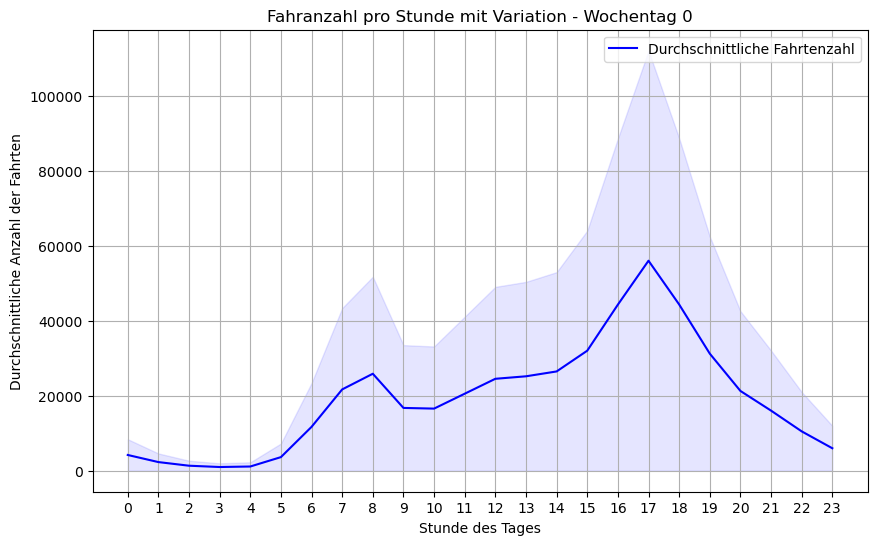

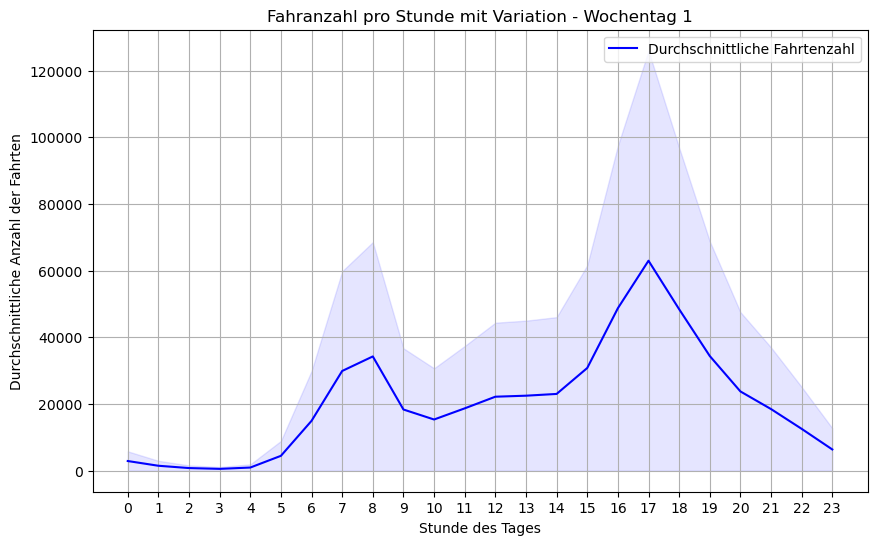

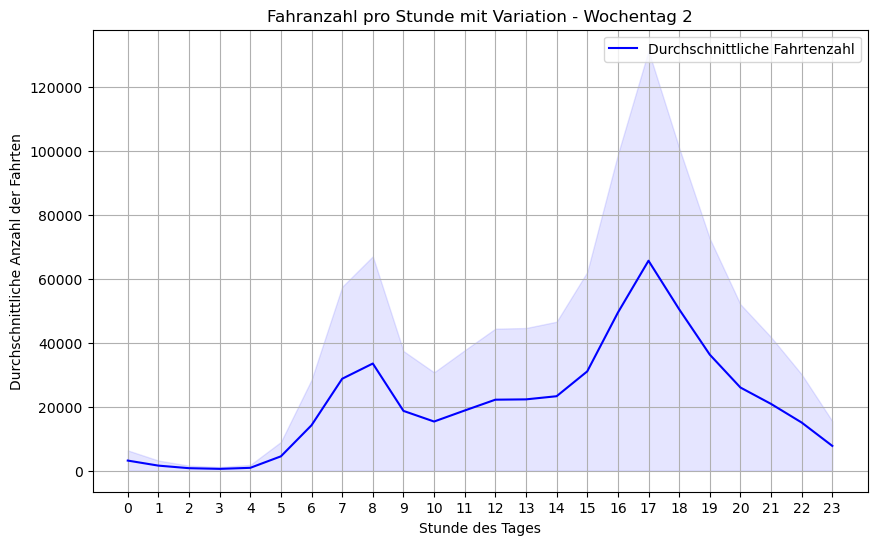

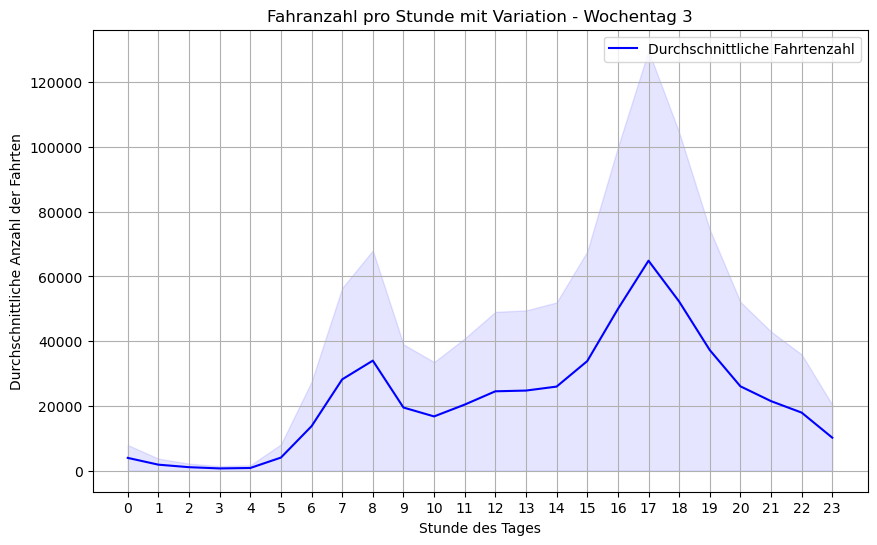

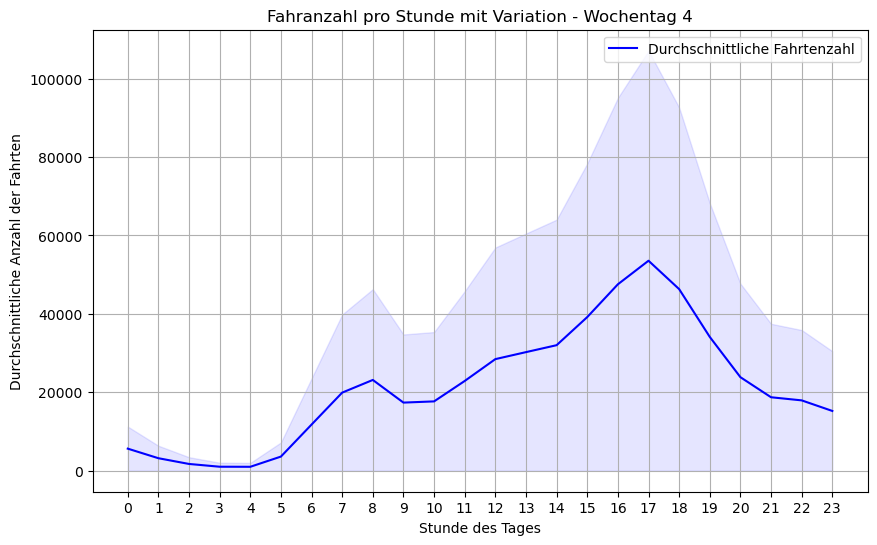

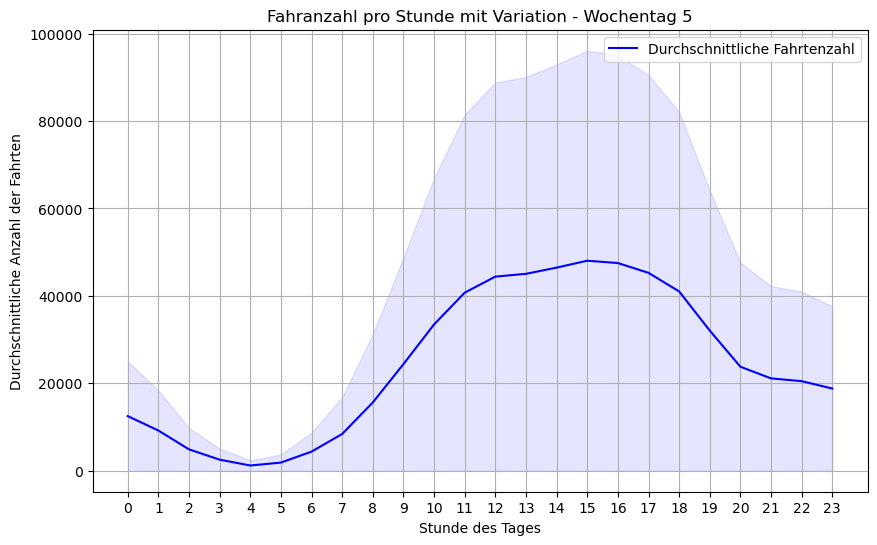

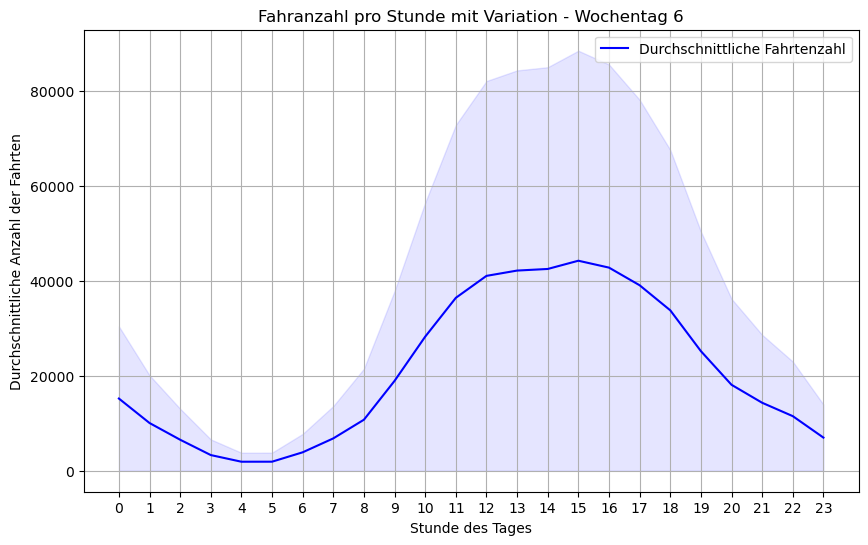

In [23]:


# Berechnung der durchschnittlichen Fahrtenzahl und Standardabweichung pro Stunde und Wochentag
stats = df.groupby(['weekday', 'hour']).agg(
    average_rides=('ride_id', 'count'),  # Ersetzen Sie 'ride_id' durch eine geeignete Zählspalte
    std_dev=('ride_id', 'count')  # Beispiel: Verwenden Sie dieselbe Spalte für ein einfaches Beispiel
).reset_index()

# Erstellung eines Plots für jeden Wochentag
for weekday in range(7):
    day_stats = stats[stats['weekday'] == weekday]

    plt.figure(figsize=(10, 6))
    plt.plot(day_stats['hour'], day_stats['average_rides'], label='Durchschnittliche Fahrtenzahl', color='blue')

    # Hinzufügen der Schattierung
    plt.fill_between(day_stats['hour'], 
                     day_stats['average_rides'] - day_stats['std_dev'], 
                     day_stats['average_rides'] + day_stats['std_dev'], 
                     color='blue', alpha=0.1)

    plt.title(f'Fahranzahl pro Stunde mit Variation - Wochentag {weekday}')
    plt.xlabel('Stunde des Tages')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True)
    plt.show()


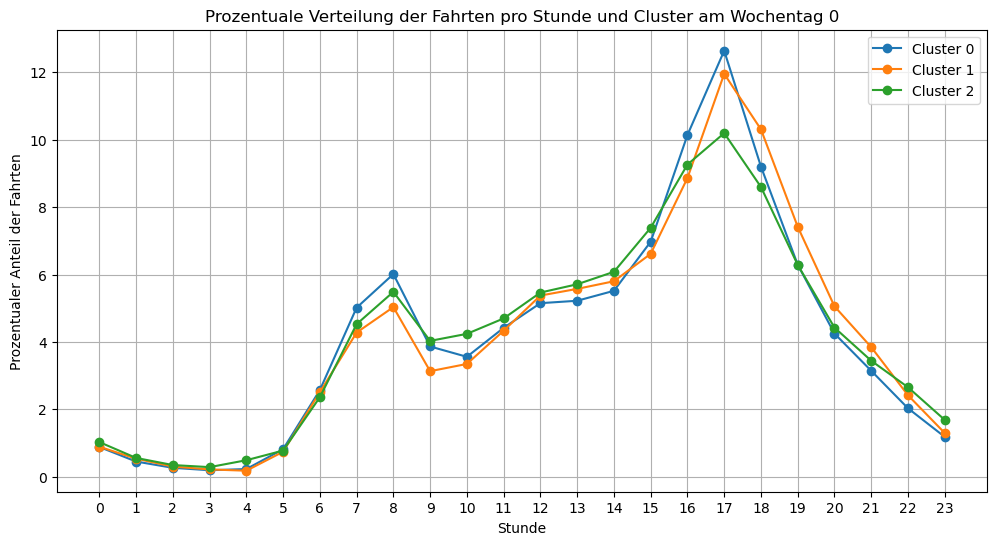

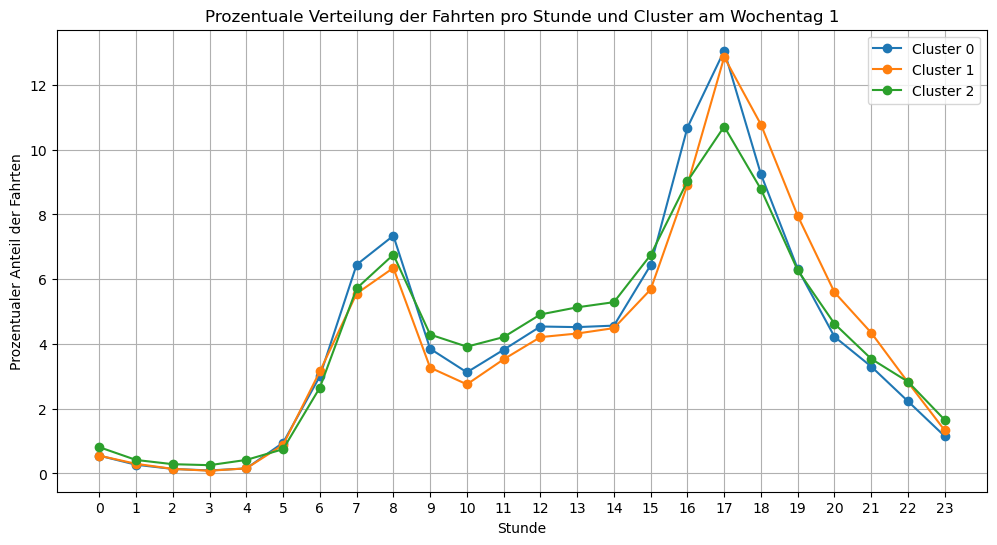

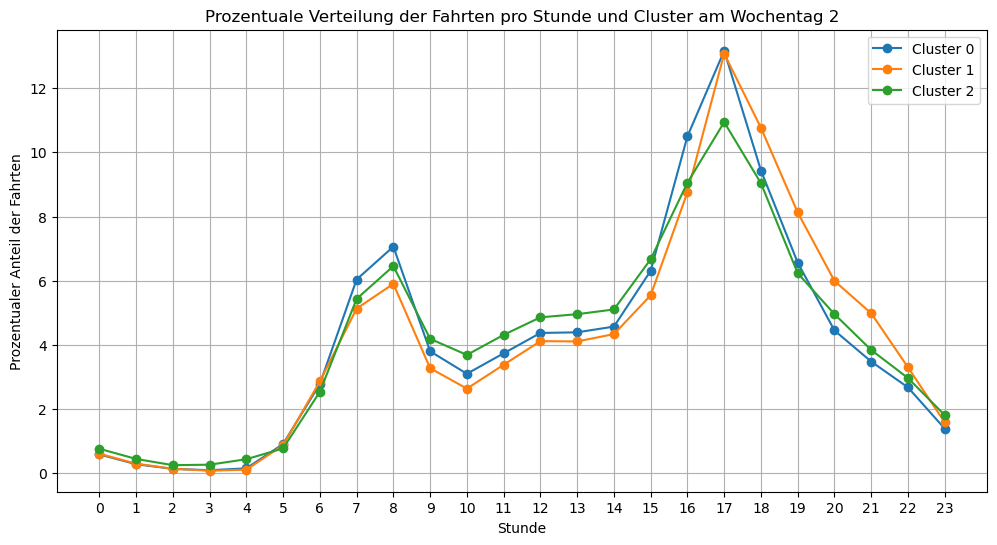

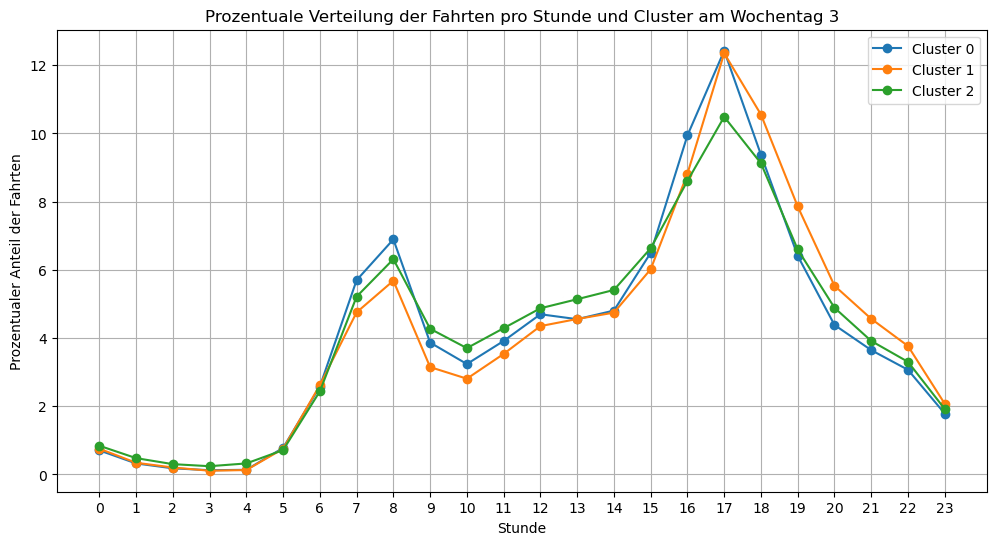

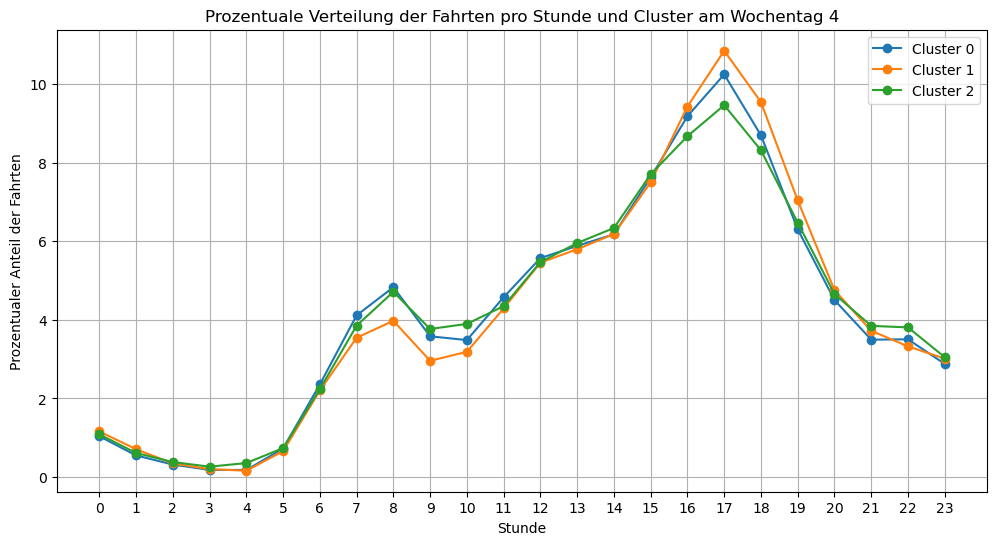

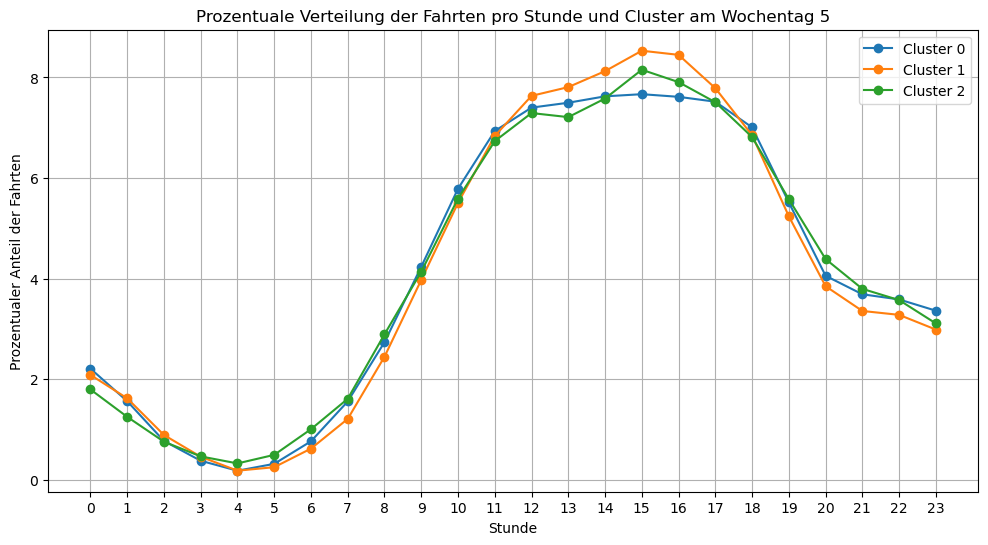

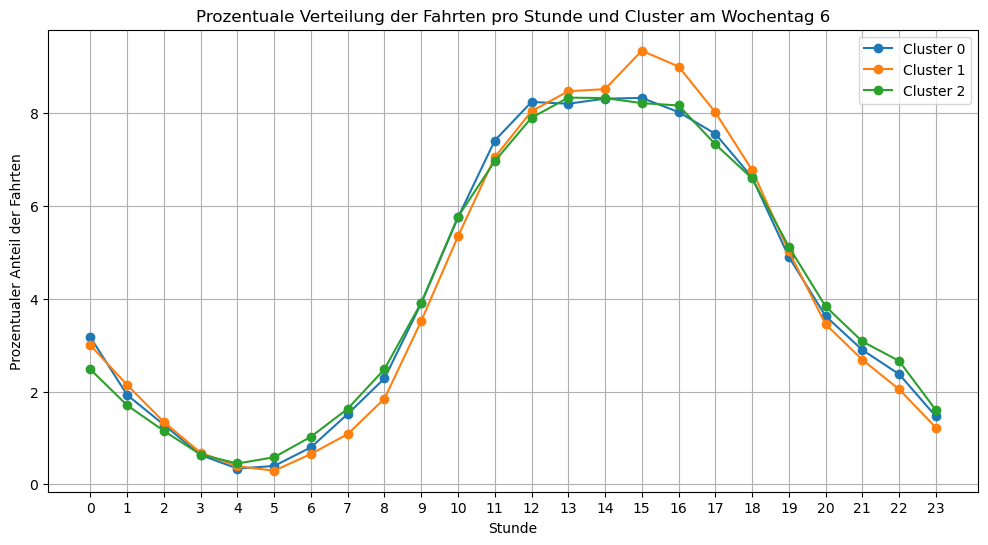

In [187]:
# 1. Gesamtzahl der Fahrten pro Cluster und Wochentag
total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')

# 2. Stündliche Fahrten pro Cluster und Wochentag
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')

# 3. Zusammenführen der Gesamt- und stündlichen Fahrten
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])

# 4. Prozentualen Anteil berechnen
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:  # Überprüfung, ob der Cluster vorhanden ist
            data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
            plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')
        
    plt.title(f'Prozentuale Verteilung der Fahrten pro Stunde und Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Prozentualer Anteil der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()


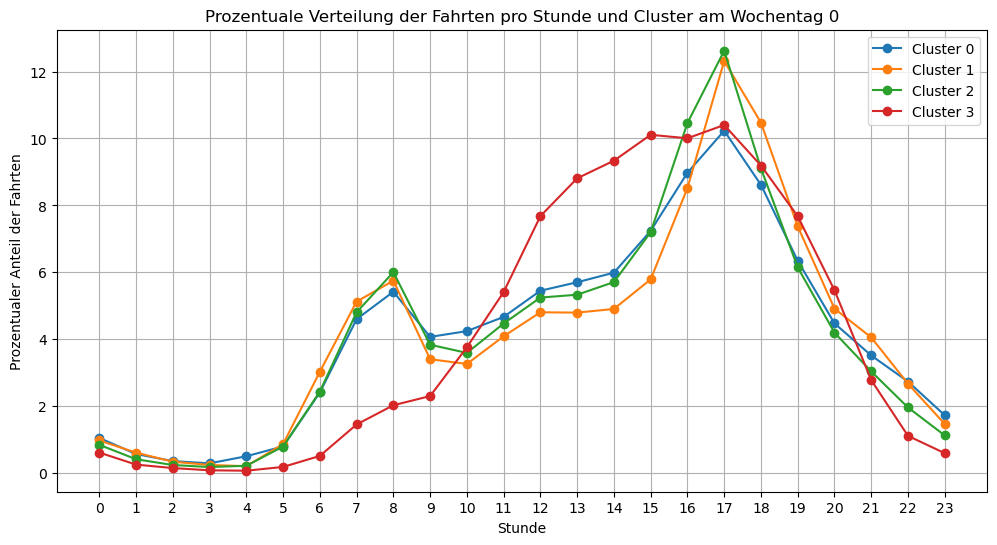

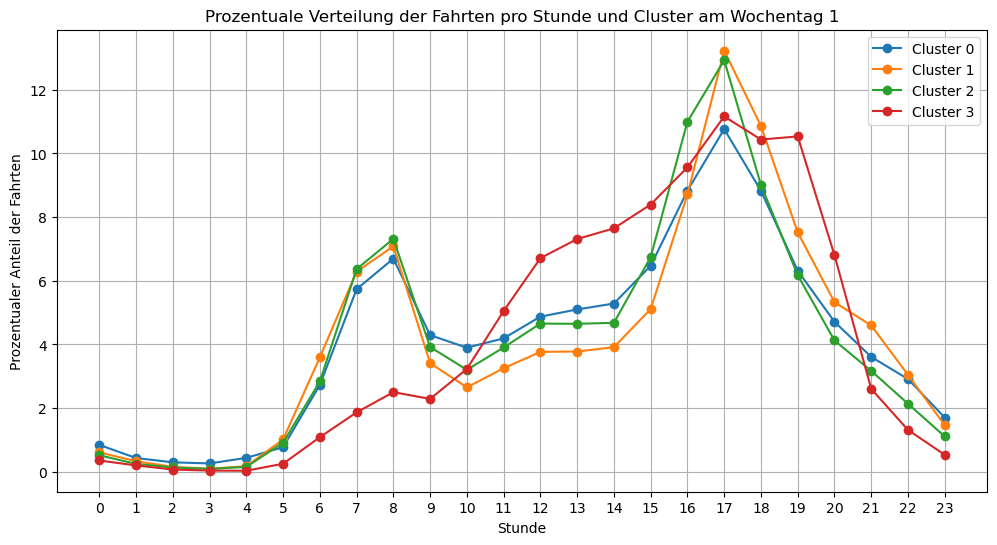

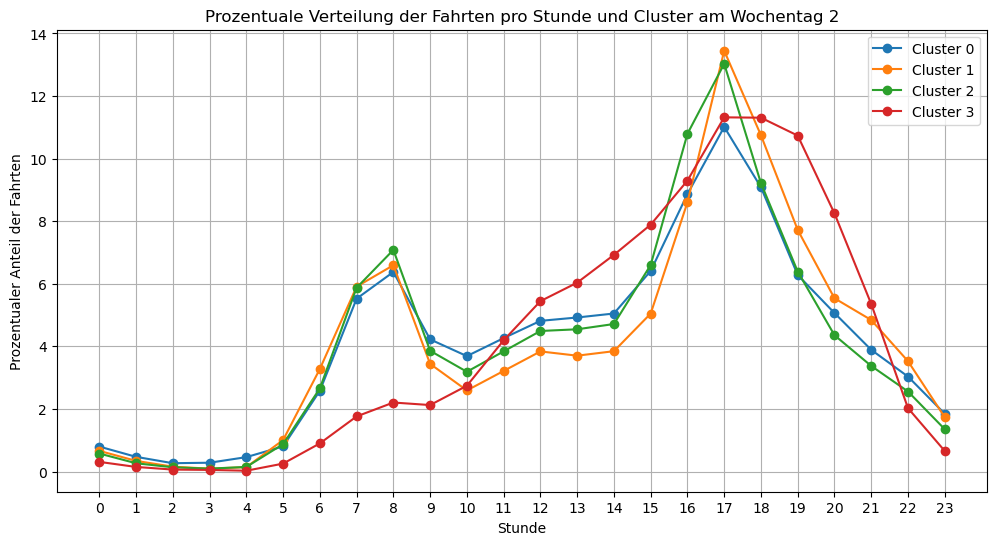

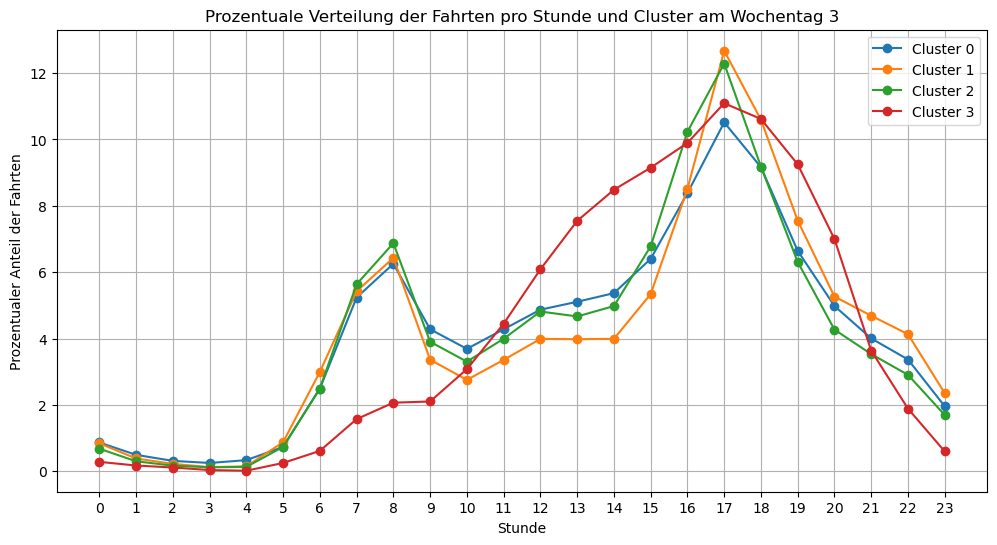

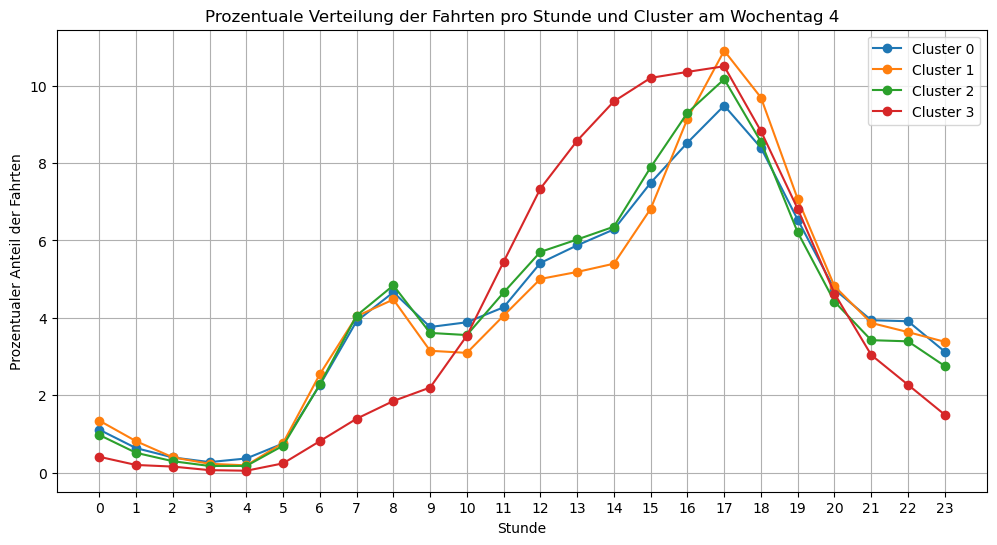

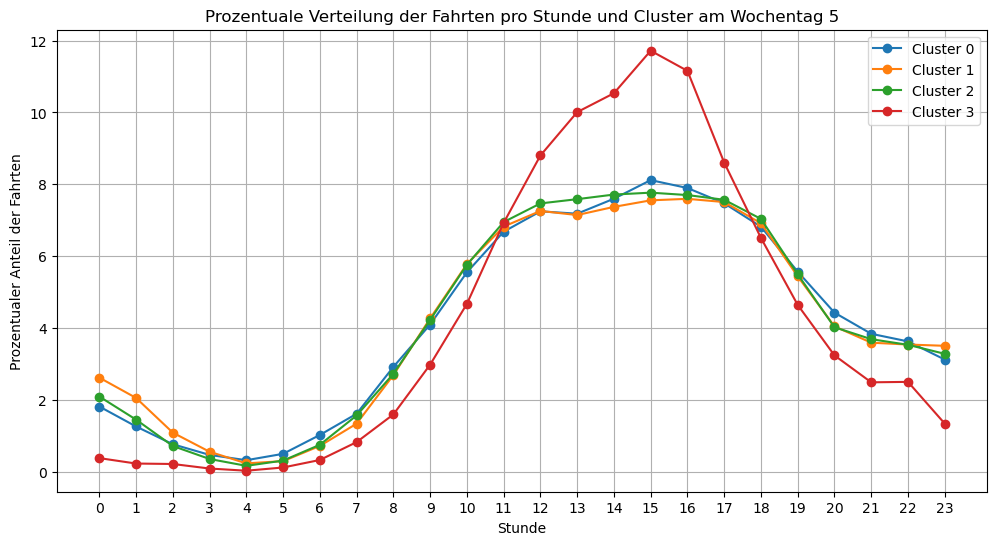

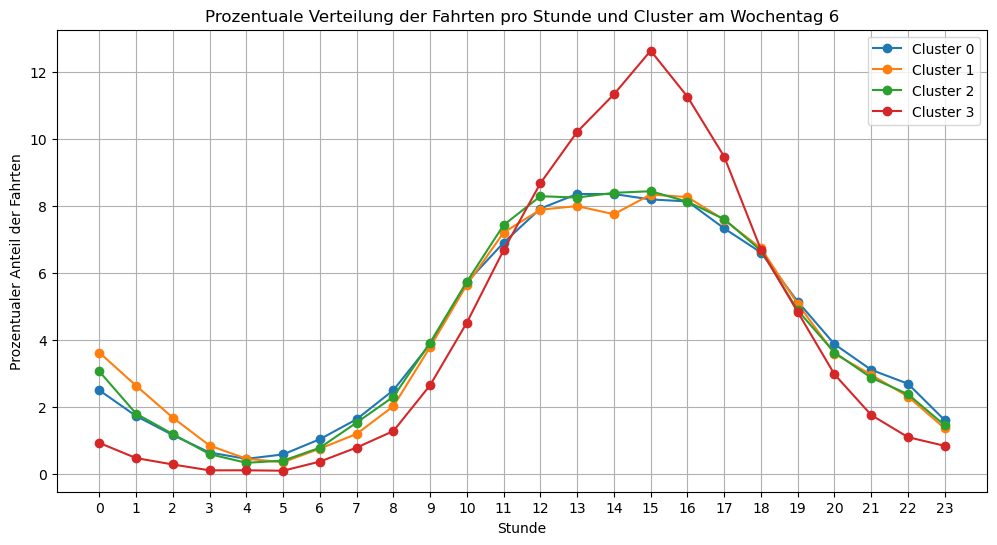

In [260]:
# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# 1. Gesamtzahl der Fahrten pro Cluster und Wochentag
total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')

# 2. Stündliche Fahrten pro Cluster und Wochentag
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')

# 3. Zusammenführen der Gesamt- und stündlichen Fahrten
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])

# 4. Prozentualen Anteil berechnen
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:  # Überprüfung, ob der Cluster vorhanden ist
            data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
            plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')
        
    plt.title(f'Prozentuale Verteilung der Fahrten pro Stunde und Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Prozentualer Anteil der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

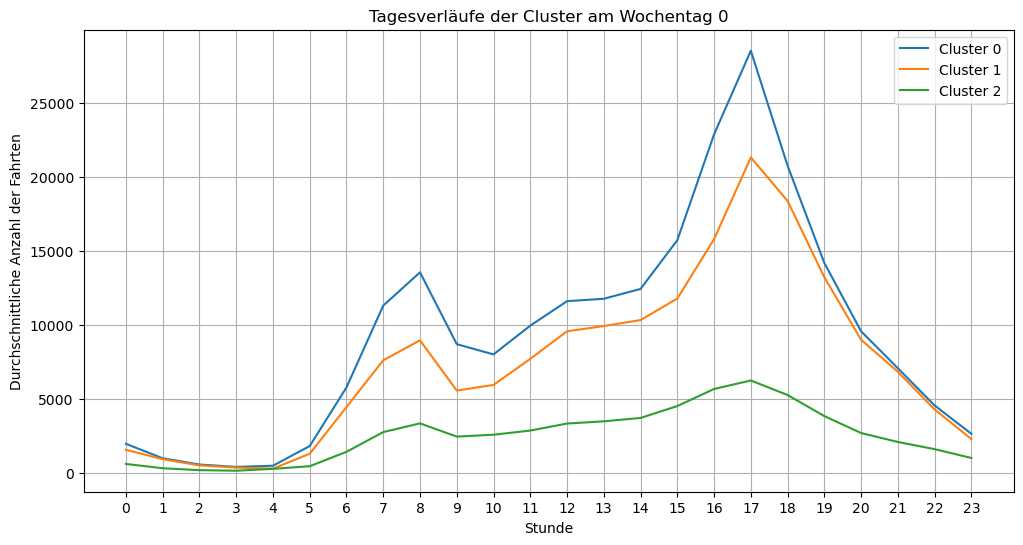

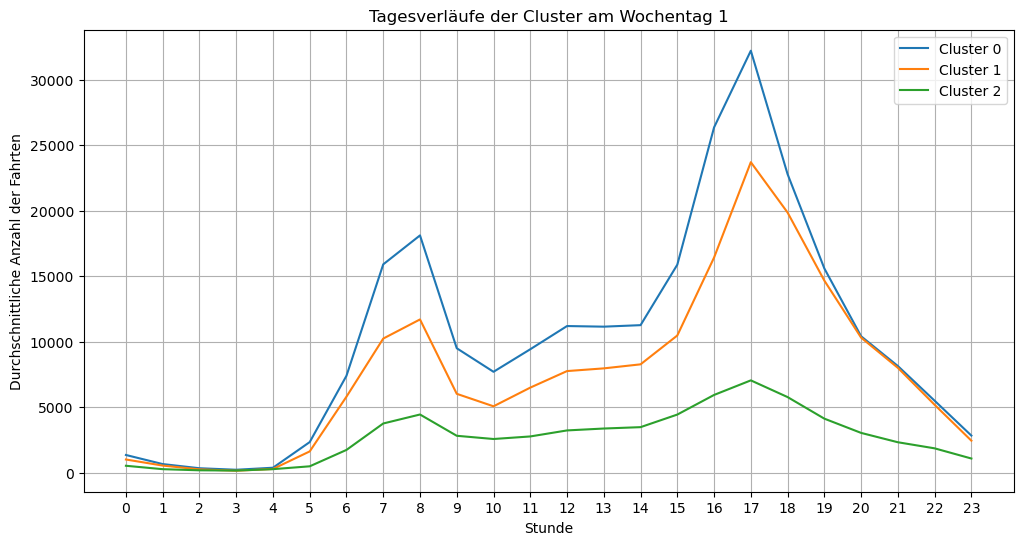

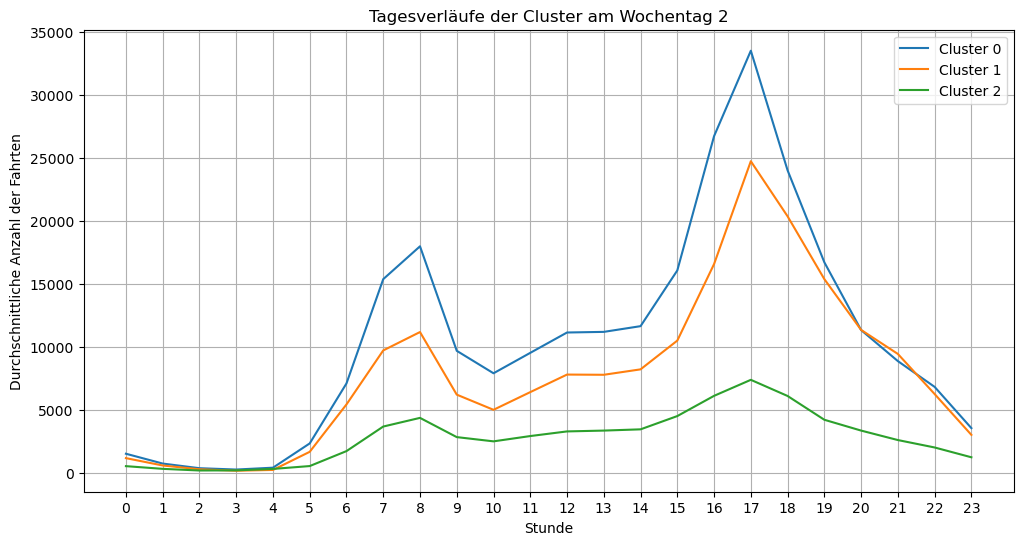

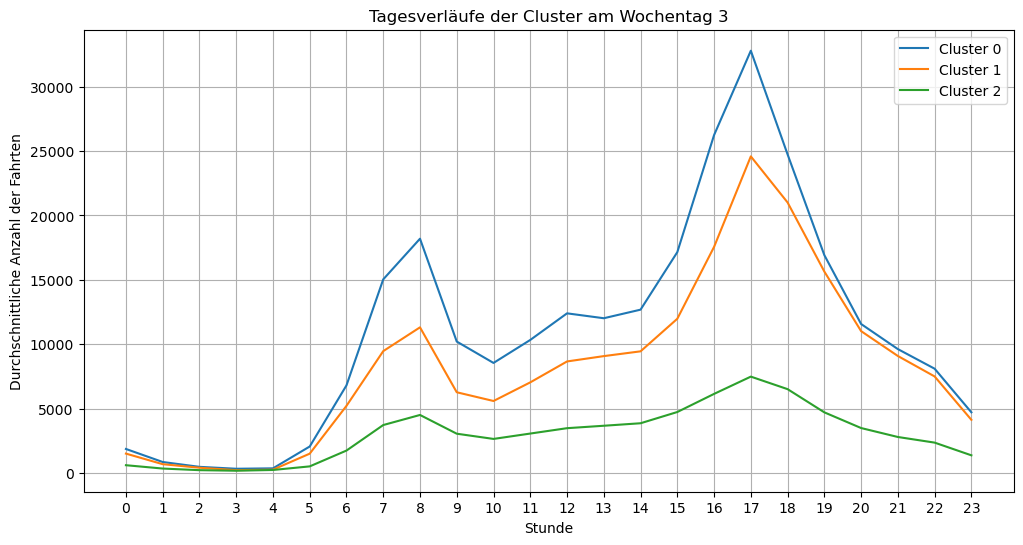

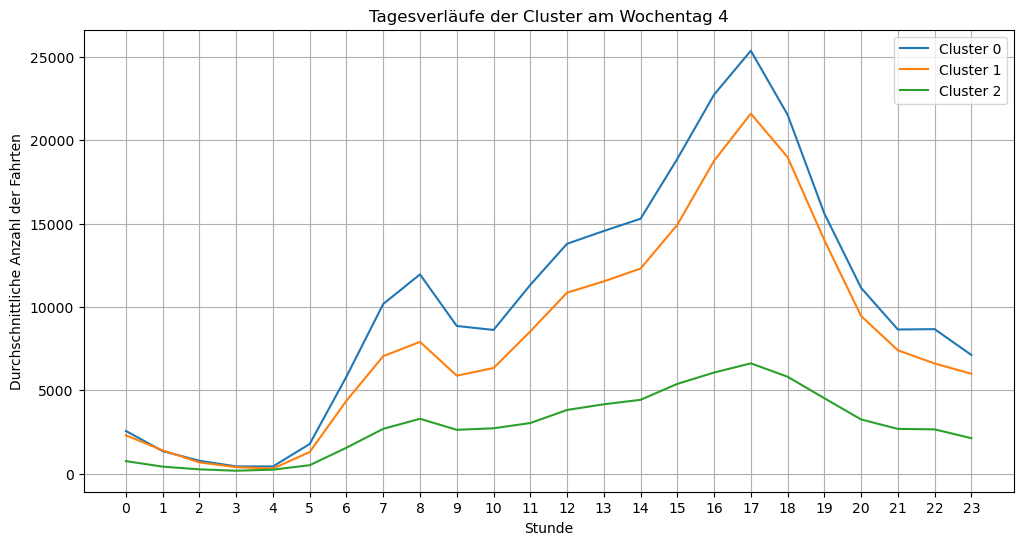

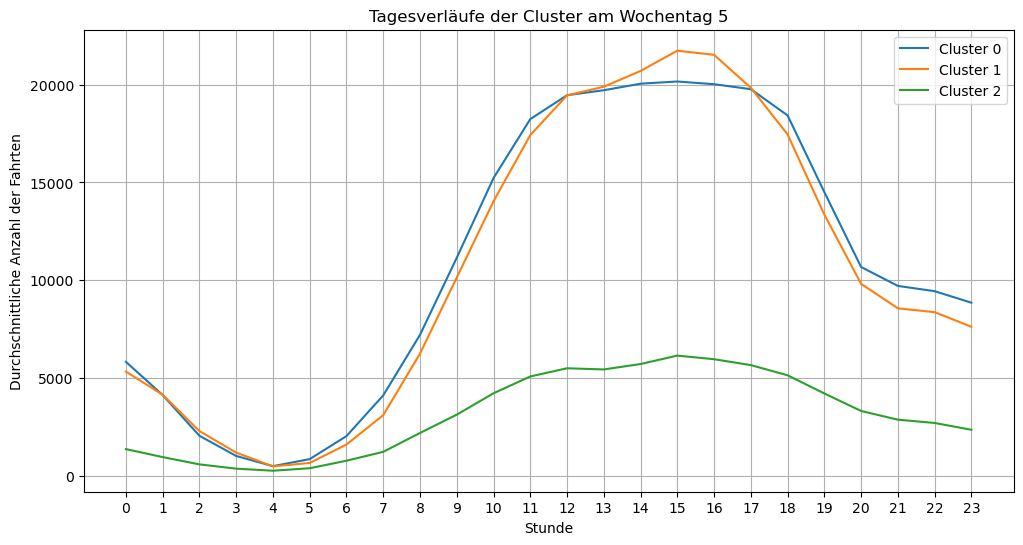

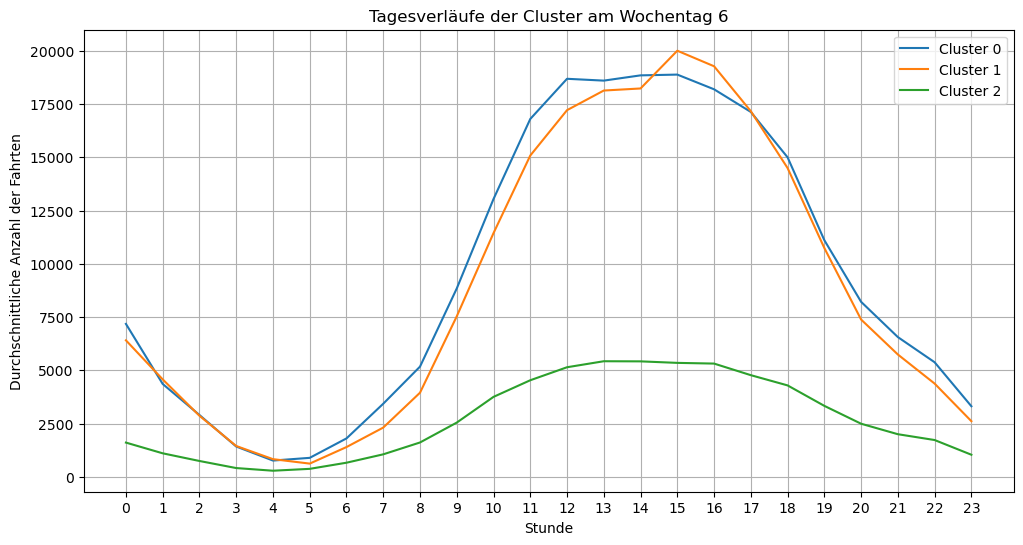

In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Umwandlung der 'started_at' in datetime und Erstellung der 'hour' und 'weekday' Spalten, falls noch nicht vorhanden
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.weekday

# Aggregieren der Daten: Anzahl der Fahrten pro Stunde und Wochentag für jeden Cluster
agg_data = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='ride_count')

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = agg_data.pivot_table(index=['hour', 'weekday'], columns='cluster', values='ride_count', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
        plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}')
        
    plt.title(f'Tagesverläufe der Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()


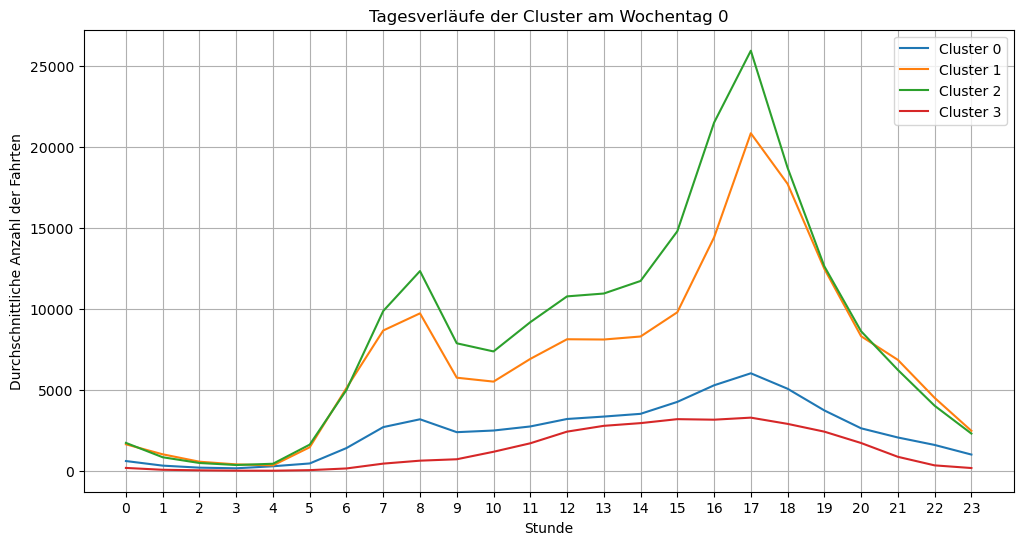

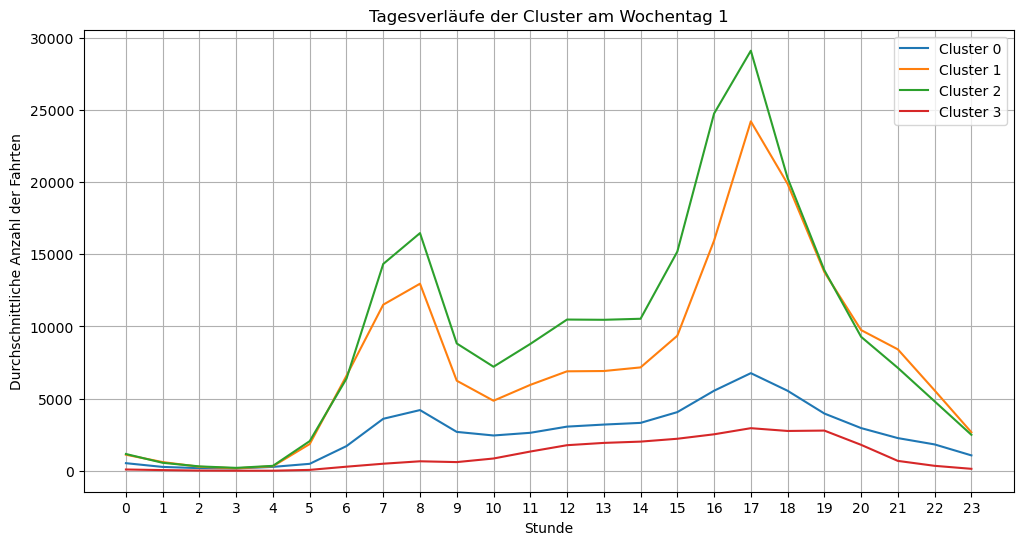

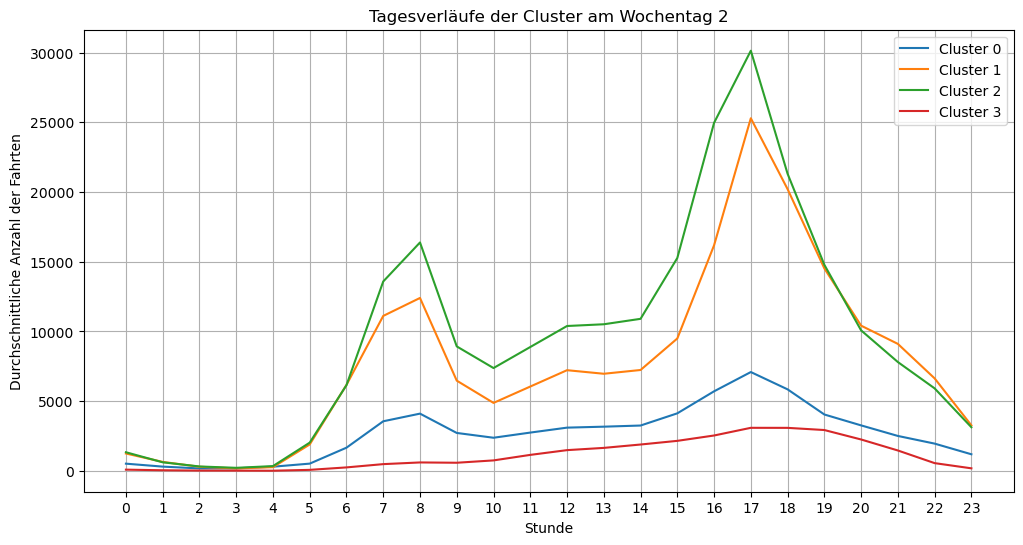

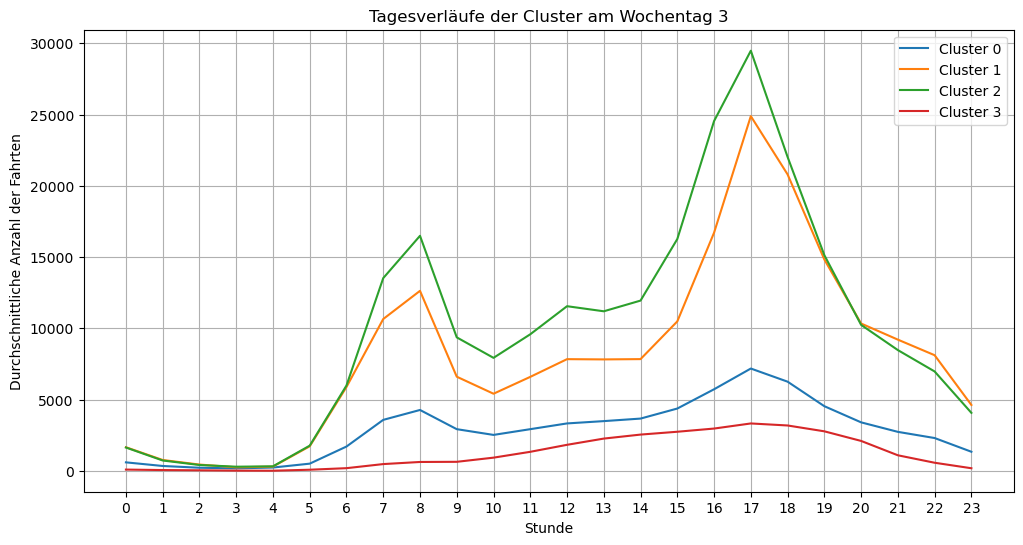

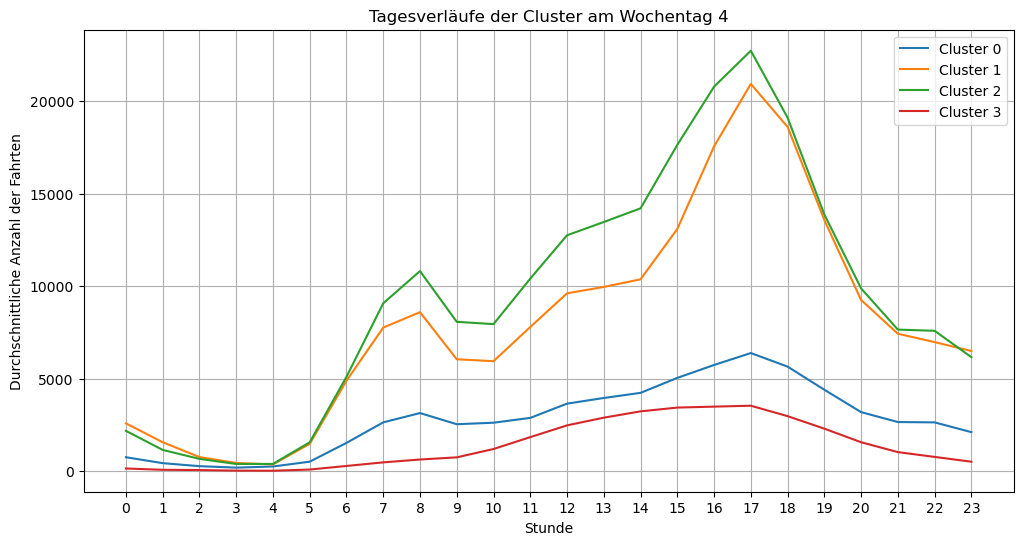

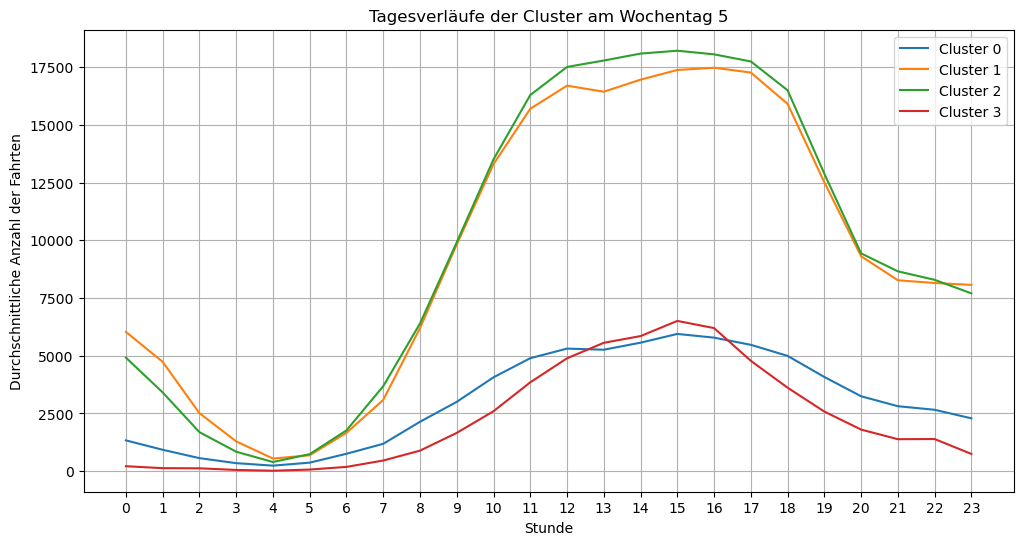

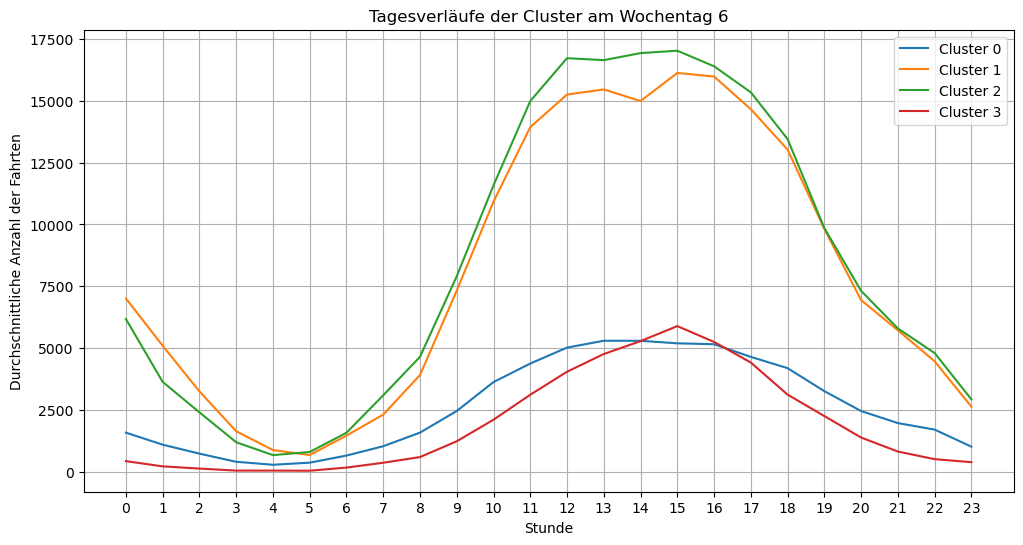

In [261]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Umwandlung der 'started_at' in datetime und Erstellung der 'hour' und 'weekday' Spalten, falls noch nicht vorhanden
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.weekday

# Aggregieren der Daten: Anzahl der Fahrten pro Stunde und Wochentag für jeden Cluster
agg_data = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='ride_count')

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = agg_data.pivot_table(index=['hour', 'weekday'], columns='cluster', values='ride_count', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
        plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}')
        
    plt.title(f'Tagesverläufe der Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

In [48]:
unique_stations = df['cluster'].dropna().reset_index()

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# Angenommen, unique_stations ist Ihr DataFrame mit den Stationen und deren Clustern

# Wir nehmen an, dass 'start_lat' und 'start_lng' die Koordinaten der Stationen sind
coords = unique_stations[['start_lat', 'start_lng']]

# Einteilung der Koordinaten in Gitterzellen
# Die Anzahl der Bins (hier 5 für jede Dimension) steuert die Größe der Zellen
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
grid = est.fit_transform(coords)
unique_stations['grid_cell'] = grid[:, 0] * 5 + grid[:, 1]  # Kombination der Bins zu einer Zell-ID

# Zählen der Stationen jedes Clusters in jeder Gitterzelle
counts_per_cell_cluster = unique_stations.groupby(['grid_cell', 'cluster']).size().unstack(fill_value=0)

print(counts_per_cell_cluster.head())


cluster     0  1  2  3  4
grid_cell                
1.0         5  0  0  0  0
2.0        55  0  0  0  0
3.0        63  0  0  0  0
4.0        43  0  0  0  0
6.0        40  0  0  0  0


In [75]:
from scipy.stats import chi2_contingency

data = counts_per_cell_cluster
# Durchführung des Chi-Quadrat-Tests
chi2, p, dof, expected = chi2_contingency(data)

print(f"Chi-Quadrat Statistik: {chi2}")
print(f"P-Wert: {p}")

Chi-Quadrat Statistik: 116.57627884230604
P-Wert: 0.00022645177666925196


In [141]:
unique_stations

<bound method Series.dropna of 0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1277    1.0
1278    4.0
1279    4.0
1280    0.0
1281    0.0
Name: cluster, Length: 1282, dtype: float64>

In [189]:
import folium
unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)
# Erstellung einer Karte zentriert um die durchschnittlichen Koordinaten
map_clusters = folium.Map(location=[unique_stations['start_lat'].mean(), unique_stations['start_lng'].mean()], zoom_start=13)

# Farben für die Cluster
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Hinzufügen der Stationen zur Karte mit farbiger Markierung je nach Cluster
for lat, lon, cluster in zip(unique_stations['start_lat'], unique_stations['start_lng'], unique_stations['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],  # Um sicherzustellen, dass die Farbenindexierung innerhalb der Grenzen bleibt
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.7).add_to(map_clusters)

# Anzeige der Karte direkt im Notebook
map_clusters

In [244]:
import folium
unique_stations_2 = unique_stations_2.dropna(subset=['cluster'])
unique_stations_2['cluster'] = unique_stations_2['cluster'].astype(int)
# Erstellung einer Karte zentriert um die durchschnittlichen Koordinaten
map_clusters = folium.Map(location=[unique_stations_2['start_lat'].mean(), unique_stations['start_lng'].mean()], zoom_start=13)

# Farben für die Cluster
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Hinzufügen der Stationen zur Karte mit farbiger Markierung je nach Cluster
for lat, lon, cluster in zip(unique_stations_2['start_lat'], unique_stations['start_lng'], unique_stations_2['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],  # Um sicherzustellen, dass die Farbenindexierung innerhalb der Grenzen bleibt
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.7).add_to(map_clusters)

# Anzeige der Karte direkt im Notebook
map_clusters